# setup

In [1]:
import logging
logging.getLogger().setLevel(logging.ERROR) # suppress the SafeTensors loading messages

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%%capture
!pip install git+https://github.com/EleutherAI/sae.git

In [4]:
# you should load this before cloning repo files
# from .config import SaeConfig
# from .utils import decoder_impl

from sae.config import SaeConfig
from sae.utils import decoder_impl
from sae import Sae

Triton not installed, using eager implementation of SAE decoder.


In [5]:
import gc
import pickle
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import json
from fnmatch import fnmatch
from pathlib import Path
from typing import NamedTuple, Optional, Callable, Union, List, Tuple
# from jaxtyping import Float, Int

import einops
import torch
from torch import Tensor, nn
from huggingface_hub import snapshot_download
from natsort import natsorted
from safetensors.torch import load_model, save_model

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
from collections import Counter

## corr fns

In [7]:
def normalize_byChunks(actv_tensor, chunk_size=10000): # chunk_size: Number of rows per chunk
    mean_A = actv_tensor.mean(dim=0, keepdim=True)
    std_A = actv_tensor.std(dim=0, keepdim=True)

    num_chunks = actv_tensor.shape[0] // chunk_size

    normalized_A = np.zeros_like(actv_tensor.cpu())  # Preallocate the normalized matrix
    # normalized_A = actv_tensor.new_zeros(actv_tensor.size())

    for i in range(num_chunks):
        # print (i, num_chunks)
        start_index = i * chunk_size
        end_index = start_index + chunk_size
        chunk = actv_tensor[start_index:end_index]
        normalized_A[start_index:end_index] = (chunk - mean_A) / (std_A + 1e-8)

    # Handle any remaining rows if the data size is not perfectly divisible by chunk_size
    if actv_tensor.shape[0] % chunk_size != 0:
        start_index = num_chunks * chunk_size
        chunk = actv_tensor[start_index:]
        normalized_A[start_index:] = (chunk - mean_A) / (std_A + 1e-8)

    return torch.tensor(normalized_A)

In [8]:
def batched_correlation(reshaped_activations_A, reshaped_activations_B, batch_size=100):
    # Ensure tensors are on GPU
    # if torch.cuda.is_available():
    #     reshaped_activations_A = reshaped_activations_A.to('cuda')
    #     reshaped_activations_B = reshaped_activations_B.to('cuda')

    normalized_A = normalize_byChunks(reshaped_activations_A, chunk_size=10000)
    normalized_B = normalize_byChunks(reshaped_activations_B, chunk_size=10000)

    if torch.cuda.is_available():
        normalized_A = normalized_A.to('cuda')
        normalized_B = normalized_B.to('cuda')

    num_batches = (normalized_B.shape[1] + batch_size - 1) // batch_size
    max_values = []
    max_indices = []

    for batch in range(num_batches):
        start = batch * batch_size
        # if start % 5000 == 0:
        #     print(start)
        end = min(start + batch_size, normalized_B.shape[1])

        batch_corr_matrix = torch.matmul(normalized_A.t(), normalized_B[:, start:end]) / normalized_A.shape[0]
        max_val, max_idx = batch_corr_matrix.max(dim=0)
        max_values.append(max_val)
        max_indices.append(max_idx)  # Adjust indices for the batch offset

        del batch_corr_matrix
        torch.cuda.empty_cache()

    # return torch.cat(max_indices), torch.cat(max_values)
    return torch.cat(max_indices).cpu().numpy(), torch.cat(max_values).cpu().numpy()

## sim fns

In [9]:
import functools
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import numpy.typing as npt
import torch


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(
    R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad"
) -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def sim_random_baseline(
    rep1: torch.Tensor, rep2: torch.Tensor, sim_func: Callable, n_permutations: int = 10
) -> Dict[str, Any]:
    torch.manual_seed(1234)
    scores = []
    for _ in range(n_permutations):
        perm = torch.randperm(rep1.size(0))

        score = sim_func(rep1[perm, :], rep2)
        score = score if isinstance(score, float) else score["score"]

        scores.append(score)

    return {"baseline_scores": np.array(scores)}


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray], Dict[str, Any]],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray) -> Dict[str, Any]:
        for preprocess_func in self.preprocess_funcs:
            R = preprocess_func(R)
            Rp = preprocess_func(Rp)
        return self.similarity_func(R, Rp)

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return (
                func.__name__
                if not isinstance(func, functools.partial)
                else func.func.__name__
            )

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )

In [10]:
from typing import List, Set, Union

import numpy as np
import numpy.typing as npt
import sklearn.neighbors
import torch

# from llmcomp.measures.utils import to_numpy_if_needed


def _jac_sim_i(idx_R: Set[int], idx_Rp: Set[int]) -> float:
    return len(idx_R.intersection(idx_Rp)) / len(idx_R.union(idx_Rp))


def jaccard_similarity(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    k: int = 10,
    inner: str = "cosine",
    n_jobs: int = 8,
) -> float:
    R, Rp = to_numpy_if_needed(R, Rp)

    indices_R = nn_array_to_setlist(top_k_neighbors(R, k, inner, n_jobs))
    indices_Rp = nn_array_to_setlist(top_k_neighbors(Rp, k, inner, n_jobs))

    return float(
        np.mean(
            [_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
        )
    )


def top_k_neighbors(
    R: npt.NDArray,
    k: int,
    inner: str,
    n_jobs: int,
) -> npt.NDArray:
    # k+1 nearest neighbors, because we pass in all the data, which means that a point
    # will be the nearest neighbor to itself. We remove this point from the results and
    # report only the k nearest neighbors distinct from the point itself.
    nns = sklearn.neighbors.NearestNeighbors(
        n_neighbors=k + 1, metric=inner, n_jobs=n_jobs
    )
    nns.fit(R)
    _, nns = nns.kneighbors(R)
    return nns[:, 1:]


def nn_array_to_setlist(nn: npt.NDArray) -> List[Set[int]]:
    return [set(idx) for idx in nn]

In [11]:
import functools
import logging
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from dataclasses import field
from typing import Any
from typing import Callable
from typing import get_args
from typing import List
from typing import Literal
from typing import Optional
from typing import Protocol
from typing import Tuple
from typing import Union

import numpy as np
import numpy.typing as npt
import torch
from einops import rearrange
# from loguru import logger

log = logging.getLogger(__name__)


SHAPE_TYPE = Literal["nd", "ntd", "nchw"]

ND_SHAPE, NTD_SHAPE, NCHW_SHAPE = get_args(SHAPE_TYPE)[0], get_args(SHAPE_TYPE)[1], get_args(SHAPE_TYPE)[2]


class SimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float: ...


class RSMSimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE, n_jobs: int
    ) -> float: ...


@dataclass
class BaseSimilarityMeasure(ABC):
    larger_is_more_similar: bool
    is_symmetric: bool

    is_metric: bool | None = None
    invariant_to_affine: bool | None = None
    invariant_to_invertible_linear: bool | None = None
    invariant_to_ortho: bool | None = None
    invariant_to_permutation: bool | None = None
    invariant_to_isotropic_scaling: bool | None = None
    invariant_to_translation: bool | None = None
    name: str = field(init=False)

    def __post_init__(self):
        self.name = self.__class__.__name__

    @abstractmethod
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        raise NotImplementedError


class FunctionalSimilarityMeasure(BaseSimilarityMeasure):
    @abstractmethod
    def __call__(self, output_a: torch.Tensor | npt.NDArray, output_b: torch.Tensor | npt.NDArray) -> float:
        raise NotImplementedError


@dataclass(kw_only=True)
class RepresentationalSimilarityMeasure(BaseSimilarityMeasure):
    sim_func: SimilarityFunction

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float:
        return self.sim_func(R, Rp, shape)


class RSMSimilarityMeasure(RepresentationalSimilarityMeasure):
    sim_func: RSMSimilarityFunction

    @staticmethod
    def estimate_good_number_of_jobs(R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray) -> int:
        # RSMs in are NxN (or DxD) so the number of jobs should roughly scale quadratically with increase in N (or D).
        # False! As long as sklearn-native metrics are used, they will use parallel implementations regardless of job
        # count. Each job would spawn their own threads, which leads to oversubscription of cores and thus slowdown.
        # This seems to be not fully correct (n_jobs=2 seems to actually use two cores), but using n_jobs=1 seems the
        # fastest.
        return 1

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
        n_jobs: Optional[int] = None,
    ) -> float:
        if n_jobs is None:
            n_jobs = self.estimate_good_number_of_jobs(R, Rp)
        return self.sim_func(R, Rp, shape, n_jobs=n_jobs)


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad") -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def normalize_row_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord=2, axis=1, keepdims=True)


def standardize(R: npt.NDArray) -> npt.NDArray:
    return (R - R.mean(axis=0, keepdims=True)) / R.std(axis=0)


def double_center(x: npt.NDArray) -> npt.NDArray:
    return x - x.mean(axis=0, keepdims=True) - x.mean(axis=1, keepdims=True) + x.mean()


def align_spatial_dimensions(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Aligns spatial representations by resizing them to the smallest spatial dimension.
    Subsequent aligned spatial representations are flattened, with the spatial aligned representations
    moving into the *sample* dimension.
    """
    R_re, Rp_re = resize_wh_reps(R, Rp)
    R_re = rearrange(R_re, "n c h w -> (n h w) c")
    Rp_re = rearrange(Rp_re, "n c h w -> (n h w) c")
    if R_re.shape[0] > 5000:
        logger.info(f"Got {R_re.shape[0]} samples in N after flattening. Subsampling to reduce compute.")
        subsample = R_re.shape[0] // 5000
        R_re = R_re[::subsample]
        Rp_re = Rp_re[::subsample]

    return R_re, Rp_re


def average_pool_downsample(R, resize: bool, new_size: tuple[int, int]):
    if not resize:
        return R  # do nothing
    else:
        is_numpy = isinstance(R, np.ndarray)
        R_torch = torch.from_numpy(R) if is_numpy else R
        R_torch = torch.nn.functional.adaptive_avg_pool2d(R_torch, new_size)
        return R_torch.numpy() if is_numpy else R_torch


def resize_wh_reps(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Function for resizing spatial representations that are not the same size.
    Does through fourier transform and resizing.

    Args:
        R: numpy array of shape  [batch_size, height, width, num_channels]
        RP: numpy array of shape [batch_size, height, width, num_channels]

    Returns:
        fft_acts1: numpy array of shape [batch_size, (new) height, (new) width, num_channels]
        fft_acts2: numpy array of shape [batch_size, (new) height, (new) width, num_channels]

    """
    height1, width1 = R.shape[2], R.shape[3]
    height2, width2 = Rp.shape[2], Rp.shape[3]
    if height1 != height2 or width1 != width2:
        height = min(height1, height2)
        width = min(width1, width2)
        new_size = [height, width]
        resize = True
    else:
        height = height1
        width = width1
        new_size = None
        resize = False

    # resize and preprocess with fft
    avg_ds1 = average_pool_downsample(R, resize=resize, new_size=new_size)
    avg_ds2 = average_pool_downsample(Rp, resize=resize, new_size=new_size)
    return avg_ds1, avg_ds2


def fft_resize(images, resize=False, new_size=None):
    """Function for applying DFT and resizing.

    This function takes in an array of images, applies the 2-d fourier transform
    and resizes them according to new_size, keeping the frequencies that overlap
    between the two sizes.

    Args:
              images: a numpy array with shape
                      [batch_size, height, width, num_channels]
              resize: boolean, whether or not to resize
              new_size: a tuple (size, size), with height and width the same

    Returns:
              im_fft_downsampled: a numpy array with shape
                           [batch_size, (new) height, (new) width, num_channels]
    """
    assert len(images.shape) == 4, "expecting images to be" "[batch_size, height, width, num_channels]"
    if resize:
        # FFT --> remove high frequencies --> inverse FFT
        im_complex = images.astype("complex64")
        im_fft = np.fft.fft2(im_complex, axes=(1, 2))
        im_shifted = np.fft.fftshift(im_fft, axes=(1, 2))

        center_width = im_shifted.shape[2] // 2
        center_height = im_shifted.shape[1] // 2
        half_w = new_size[0] // 2
        half_h = new_size[1] // 2
        cropped_fft = im_shifted[
            :, center_height - half_h : center_height + half_h, center_width - half_w : center_width + half_w, :
        ]
        cropped_fft_shifted_back = np.fft.ifft2(cropped_fft, axes=(1, 2))
        return cropped_fft_shifted_back.real
    else:
        return images


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray, SHAPE_TYPE], float],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray, shape: SHAPE_TYPE) -> float:
        try:
            for preprocess_func in self.preprocess_funcs:
                R = preprocess_func(R)
                Rp = preprocess_func(Rp)
            return self.similarity_func(R, Rp, shape)
        except ValueError as e:
            log.info(f"Pipeline failed: {e}")
            return np.nan

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return func.__name__ if not isinstance(func, functools.partial) else func.func.__name__

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )


def flatten(*args: Union[torch.Tensor, npt.NDArray], shape: SHAPE_TYPE) -> List[Union[torch.Tensor, npt.NDArray]]:
    if shape == "ntd":
        return list(map(flatten_nxtxd_to_ntxd, args))
    elif shape == "nd":
        return list(args)
    elif shape == "nchw":
        return list(map(flatten_nxcxhxw_to_nxchw, args))  # Flattening non-trivial for nchw
    else:
        raise ValueError("Unknown shape of representations. Must be one of 'ntd', 'nchw', 'nd'.")


def flatten_nxtxd_to_ntxd(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.flatten(R, start_dim=0, end_dim=1)
    log.debug("Shape after flattening: %s", str(R.shape))
    return R


def flatten_nxcxhxw_to_nxchw(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.reshape(R, (R.shape[0], -1))
    log.debug("Shape after flattening: %s", str(R.shape))
    return R

In [12]:
import scipy.optimize

def permutation_procrustes(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    optimal_permutation_alignment: Optional[Tuple[npt.NDArray, npt.NDArray]] = None,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    R, Rp = adjust_dimensionality(R, Rp)

    if not optimal_permutation_alignment:
        PR, PRp = scipy.optimize.linear_sum_assignment(R.T @ Rp, maximize=True)  # returns column assignments
        optimal_permutation_alignment = (PR, PRp)
    PR, PRp = optimal_permutation_alignment
    return float(np.linalg.norm(R[:, PR] - Rp[:, PRp], ord="fro"))

In [13]:
from typing import Optional
from typing import Union

import numpy as np
import numpy.typing as npt
import scipy.spatial.distance
import scipy.stats
import sklearn.metrics
import torch
# from repsim.measures.utils import flatten
# from repsim.measures.utils import RSMSimilarityMeasure
# from repsim.measures.utils import SHAPE_TYPE
# from repsim.measures.utils import to_numpy_if_needed


def representational_similarity_analysis(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    inner="correlation",
    outer="spearman",
    n_jobs: Optional[int] = None,
) -> float:
    """Representational similarity analysis

    Args:
        R (Union[torch.Tensor, npt.NDArray]): N x D representation
        Rp (Union[torch.Tensor, npt.NDArray]): N x D' representation
        inner (str, optional): inner similarity function for RSM. Must be one of
            scipy.spatial.distance.pdist identifiers . Defaults to "correlation".
        outer (str, optional): outer similarity function that compares RSMs. Defaults to
             "spearman". Must be one of "spearman", "euclidean"

    Returns:
        float: _description_
    """
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)

    if inner == "correlation":
        # n_jobs only works if metric is in PAIRWISE_DISTANCES as defined in sklearn, i.e., not for correlation.
        # But correlation = 1 - cosine dist of row-centered data, so we use the faster cosine metric and center the data.
        R = R - R.mean(axis=1, keepdims=True)
        S = scipy.spatial.distance.squareform(  # take the lower triangle of RSM
            1 - sklearn.metrics.pairwise_distances(R, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
        Rp = Rp - Rp.mean(axis=1, keepdims=True)
        Sp = scipy.spatial.distance.squareform(
            1 - sklearn.metrics.pairwise_distances(Rp, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
    elif inner == "euclidean":
        # take the lower triangle of RSM
        S = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(R, metric=inner, n_jobs=n_jobs), checks=False
        )
        Sp = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(Rp, metric=inner, n_jobs=n_jobs), checks=False
        )
    else:
        raise NotImplementedError(f"{inner=}")

    if outer == "spearman":
        return scipy.stats.spearmanr(S, Sp).statistic  # type:ignore
    elif outer == "euclidean":
        return float(np.linalg.norm(S - Sp, ord=2))
    else:
        raise ValueError(f"Unknown outer similarity function: {outer}")


class RSA(RSMSimilarityMeasure):
    def __init__(self):
        # choice of inner/outer in __call__ if fixed to default values, so these values are always the same
        super().__init__(
            sim_func=representational_similarity_analysis,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

In [14]:
##################################################################################
# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py
# Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
The core code for applying Canonical Correlation Analysis to deep networks.

This module contains the core functions to apply canonical correlation analysis
to deep neural networks. The main function is get_cca_similarity, which takes in
two sets of activations, typically the neurons in two layers and their outputs
on all of the datapoints D = [d_1,...,d_m] that have been passed through.

Inputs have shape (num_neurons1, m), (num_neurons2, m). This can be directly
applied used on fully connected networks. For convolutional layers, the 3d block
of neurons can either be flattened entirely, along channels, or alternatively,
the dft_ccas (Discrete Fourier Transform) module can be used.

See:
https://arxiv.org/abs/1706.05806
https://arxiv.org/abs/1806.05759
for full details.

"""
import numpy as np
# from repsim.measures.utils import align_spatial_dimensions

num_cca_trials = 5


def positivedef_matrix_sqrt(array):
    """Stable method for computing matrix square roots, supports complex matrices.

    Args:
              array: A numpy 2d array, can be complex valued that is a positive
                     definite symmetric (or hermitian) matrix

    Returns:
              sqrtarray: The matrix square root of array
    """
    w, v = np.linalg.eigh(array)
    #  A - np.dot(v, np.dot(np.diag(w), v.T))
    wsqrt = np.sqrt(w)
    sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
    return sqrtarray


def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon):
    """Takes covariance between X, Y, and removes values of small magnitude.

    Args:
              sigma_xx: 2d numpy array, variance matrix for x
              sigma_xy: 2d numpy array, crossvariance matrix for x,y
              sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
                        (conjugate) transpose of sigma_xy
              sigma_yy: 2d numpy array, variance matrix for y
              epsilon : cutoff value for norm below which directions are thrown
                         away

    Returns:
              sigma_xx_crop: 2d array with low x norm directions removed
              sigma_xy_crop: 2d array with low x and y norm directions removed
              sigma_yx_crop: 2d array with low x and y norm directiosn removed
              sigma_yy_crop: 2d array with low y norm directions removed
              x_idxs: indexes of sigma_xx that were removed
              y_idxs: indexes of sigma_yy that were removed
    """

    x_diag = np.abs(np.diagonal(sigma_xx))
    y_diag = np.abs(np.diagonal(sigma_yy))
    x_idxs = x_diag >= epsilon
    y_idxs = y_diag >= epsilon

    sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
    sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
    sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
    sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

    return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon, verbose=True):
    """Main cca computation function, takes in variances and crossvariances.

    This function takes in the covariances and cross covariances of X, Y,
    preprocesses them (removing small magnitudes) and outputs the raw results of
    the cca computation, including cca directions in a rotated space, and the
    cca correlation coefficient values.

    Args:
              sigma_xx: 2d numpy array, (num_neurons_x, num_neurons_x)
                        variance matrix for x
              sigma_xy: 2d numpy array, (num_neurons_x, num_neurons_y)
                        crossvariance matrix for x,y
              sigma_yx: 2d numpy array, (num_neurons_y, num_neurons_x)
                        crossvariance matrix for x,y (conj) transpose of sigma_xy
              sigma_yy: 2d numpy array, (num_neurons_y, num_neurons_y)
                        variance matrix for y
              epsilon:  small float to help with stabilizing computations
              verbose:  boolean on whether to print intermediate outputs

    Returns:
              [ux, sx, vx]: [numpy 2d array, numpy 1d array, numpy 2d array]
                            ux and vx are (conj) transposes of each other, being
                            the canonical directions in the X subspace.
                            sx is the set of canonical correlation coefficients-
                            how well corresponding directions in vx, Vy correlate
                            with each other.
              [uy, sy, vy]: Same as above, but for Y space
              invsqrt_xx:   Inverse square root of sigma_xx to transform canonical
                            directions back to original space
              invsqrt_yy:   Same as above but for sigma_yy
              x_idxs:       The indexes of the input sigma_xx that were pruned
                            by remove_small
              y_idxs:       Same as above but for sigma_yy
    """

    (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon
    )

    numx = sigma_xx.shape[0]
    numy = sigma_yy.shape[0]

    if numx == 0 or numy == 0:
        return (
            [0, 0, 0],
            [0, 0, 0],
            np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy),
            x_idxs,
            y_idxs,
        )

    if verbose:
        print("adding eps to diagonal and taking inverse")
    sigma_xx += epsilon * np.eye(numx)
    sigma_yy += epsilon * np.eye(numy)
    inv_xx = np.linalg.pinv(sigma_xx)
    inv_yy = np.linalg.pinv(sigma_yy)

    if verbose:
        print("taking square root")
    invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
    invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

    if verbose:
        print("dot products...")
    arr = np.dot(invsqrt_xx, np.dot(sigma_xy, invsqrt_yy))

    if verbose:
        print("trying to take final svd")
    u, s, v = np.linalg.svd(arr)

    if verbose:
        print("computed everything!")

    return [u, np.abs(s), v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
    """Computes threshold index of decreasing nonnegative array by summing.

    This function takes in a decreasing array nonnegative floats, and a
    threshold between 0 and 1. It returns the index i at which the sum of the
    array up to i is threshold*total mass of the array.

    Args:
              array: a 1d numpy array of decreasing, nonnegative floats
              threshold: a number between 0 and 1

    Returns:
              i: index at which np.sum(array[:i]) >= threshold
    """
    assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

    for i in range(len(array)):
        if np.sum(array[:i]) / np.sum(array) >= threshold:
            return i


def create_zero_dict(compute_dirns, dimension):
    """Outputs a zero dict when neuron activation norms too small.

    This function creates a return_dict with appropriately shaped zero entries
    when all neuron activations are very small.

    Args:
              compute_dirns: boolean, whether to have zero vectors for directions
              dimension: int, defines shape of directions

    Returns:
              return_dict: a dict of appropriately shaped zero entries
    """
    return_dict = {}
    return_dict["mean"] = (np.asarray(0), np.asarray(0))
    return_dict["sum"] = (np.asarray(0), np.asarray(0))
    return_dict["cca_coef1"] = np.asarray(0)
    return_dict["cca_coef2"] = np.asarray(0)
    return_dict["idx1"] = 0
    return_dict["idx2"] = 0

    if compute_dirns:
        return_dict["cca_dirns1"] = np.zeros((1, dimension))
        return_dict["cca_dirns2"] = np.zeros((1, dimension))

    return return_dict


def get_cca_similarity(
    acts1,
    acts2,
    epsilon=0.0,
    threshold=0.98,
    compute_coefs=True,
    compute_dirns=False,
    verbose=True,
):
    """The main function for computing cca similarities.

    This function computes the cca similarity between two sets of activations,
    returning a dict with the cca coefficients, a few statistics of the cca
    coefficients, and (optionally) the actual directions.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              epsilon: small float to help stabilize computations

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.


              compute_coefs: boolean value determining whether coefficients
                             over neurons are computed. Needed for computing
                             directions

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

              verbose: Boolean, whether intermediate outputs are printed

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    # assert dimensionality equal
    assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
    # check that acts1, acts2 are transposition
    assert acts1.shape[0] < acts1.shape[1], "input must be number of neurons" "by datapoints"
    return_dict = {}

    # compute covariance with numpy function for extra stability
    numx = acts1.shape[0]
    numy = acts2.shape[0]

    covariance = np.cov(acts1, acts2)
    sigmaxx = covariance[:numx, :numx]
    sigmaxy = covariance[:numx, numx:]
    sigmayx = covariance[numx:, :numx]
    sigmayy = covariance[numx:, numx:]

    # rescale covariance to make cca computation more stable
    xmax = np.max(np.abs(sigmaxx))
    ymax = np.max(np.abs(sigmayy))
    sigmaxx /= xmax
    sigmayy /= ymax
    sigmaxy /= np.sqrt(xmax * ymax)
    sigmayx /= np.sqrt(xmax * ymax)

    ([u, s, v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs) = compute_ccas(
        sigmaxx, sigmaxy, sigmayx, sigmayy, epsilon=epsilon, verbose=verbose
    )

    # if x_idxs or y_idxs is all false, return_dict has zero entries
    if (not np.any(x_idxs)) or (not np.any(y_idxs)):
        return create_zero_dict(compute_dirns, acts1.shape[1])

    if compute_coefs:
        # also compute full coefficients over all neurons
        x_mask = np.dot(x_idxs.reshape((-1, 1)), x_idxs.reshape((1, -1)))
        y_mask = np.dot(y_idxs.reshape((-1, 1)), y_idxs.reshape((1, -1)))

        return_dict["coef_x"] = u.T
        return_dict["invsqrt_xx"] = invsqrt_xx
        return_dict["full_coef_x"] = np.zeros((numx, numx))
        np.place(return_dict["full_coef_x"], x_mask, return_dict["coef_x"])
        return_dict["full_invsqrt_xx"] = np.zeros((numx, numx))
        np.place(return_dict["full_invsqrt_xx"], x_mask, return_dict["invsqrt_xx"])

        return_dict["coef_y"] = v
        return_dict["invsqrt_yy"] = invsqrt_yy
        return_dict["full_coef_y"] = np.zeros((numy, numy))
        np.place(return_dict["full_coef_y"], y_mask, return_dict["coef_y"])
        return_dict["full_invsqrt_yy"] = np.zeros((numy, numy))
        np.place(return_dict["full_invsqrt_yy"], y_mask, return_dict["invsqrt_yy"])

        # compute means
        neuron_means1 = np.mean(acts1, axis=1, keepdims=True)
        neuron_means2 = np.mean(acts2, axis=1, keepdims=True)
        return_dict["neuron_means1"] = neuron_means1
        return_dict["neuron_means2"] = neuron_means2

    if compute_dirns:
        # orthonormal directions that are CCA directions
        cca_dirns1 = (
            np.dot(
                np.dot(return_dict["full_coef_x"], return_dict["full_invsqrt_xx"]),
                (acts1 - neuron_means1),
            )
            + neuron_means1
        )
        cca_dirns2 = (
            np.dot(
                np.dot(return_dict["full_coef_y"], return_dict["full_invsqrt_yy"]),
                (acts2 - neuron_means2),
            )
            + neuron_means2
        )

    # get rid of trailing zeros in the cca coefficients
    idx1 = sum_threshold(s, threshold)
    idx2 = sum_threshold(s, threshold)

    return_dict["cca_coef1"] = s
    return_dict["cca_coef2"] = s
    return_dict["x_idxs"] = x_idxs
    return_dict["y_idxs"] = y_idxs
    # summary statistics
    return_dict["mean"] = (np.mean(s[:idx1]), np.mean(s[:idx2]))
    return_dict["sum"] = (np.sum(s), np.sum(s))

    if compute_dirns:
        return_dict["cca_dirns1"] = cca_dirns1
        return_dict["cca_dirns2"] = cca_dirns2

    return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, epsilon=1e-6, compute_dirns=True):
    """Calls get_cca_similarity multiple times while adding noise.

    This function is very similar to get_cca_similarity, and can be used if
    get_cca_similarity doesn't converge for some pair of inputs. This function
    adds some noise to the activations to help convergence.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.

              epsilon: small float to help stabilize computations

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    for trial in range(num_cca_trials):
        try:
            return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns)
        except np.linalg.LinAlgError:
            acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            if trial + 1 == num_cca_trials:
                raise

    return return_dict
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py


def top_k_pca_comps(singular_values, threshold=0.99):
    total_variance = np.sum(singular_values**2)
    explained_variance = (singular_values**2) / total_variance
    cumulative_variance = np.cumsum(explained_variance)
    return np.argmax(cumulative_variance >= threshold * total_variance) + 1


def _svcca_original(acts1, acts2):
    # Copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    # Modification: get_cca_similarity is in the same file.
    # Modification: top-k PCA component selection s.t. explained variance > 0.99 total variance
    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    # top-k PCA components only
    k1 = top_k_pca_comps(s1)
    k2 = top_k_pca_comps(s2)

    svacts1 = np.dot(s1[:k1] * np.eye(k1), V1[:k1])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k2] * np.eye(k2), V2[:k2])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    return np.mean(svcca_results["cca_coef1"])


# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py
# Modification: get_cca_similarity is in the same file.
def compute_pwcca(acts1, acts2, epsilon=0.0):
    """Computes projection weighting for weighting CCA coefficients

    Args:
         acts1: 2d numpy array, shaped (neurons, num_datapoints)
         acts2: 2d numpy array, shaped (neurons, num_datapoints)

    Returns:
         Original cca coefficient mean and weighted mean

    """
    sresults = get_cca_similarity(
        acts1,
        acts2,
        epsilon=epsilon,
        compute_dirns=False,
        compute_coefs=True,
        verbose=False,
    )
    if np.sum(sresults["x_idxs"]) <= np.sum(sresults["y_idxs"]):
        dirns = (
            np.dot(
                sresults["coef_x"],
                (acts1[sresults["x_idxs"]] - sresults["neuron_means1"][sresults["x_idxs"]]),
            )
            + sresults["neuron_means1"][sresults["x_idxs"]]
        )
        coefs = sresults["cca_coef1"]
        acts = acts1
        idxs = sresults["x_idxs"]
    else:
        dirns = (
            np.dot(
                sresults["coef_y"],
                (acts1[sresults["y_idxs"]] - sresults["neuron_means2"][sresults["y_idxs"]]),
            )
            + sresults["neuron_means2"][sresults["y_idxs"]]
        )
        coefs = sresults["cca_coef2"]
        acts = acts2
        idxs = sresults["y_idxs"]
    P, _ = np.linalg.qr(dirns.T)
    weights = np.sum(np.abs(np.dot(P.T, acts[idxs].T)), axis=1)
    weights = weights / np.sum(weights)

    return np.sum(weights * coefs), weights, coefs
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py


##################################################################################

from typing import Union  # noqa:e402

import numpy.typing as npt  # noqa:e402
import torch  # noqa:e402

# from repsim.measures.utils import (
#     SHAPE_TYPE,
#     flatten,
#     resize_wh_reps,
#     to_numpy_if_needed,
#     RepresentationalSimilarityMeasure,
# )  # noqa:e402


def svcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return _svcca_original(R.T, Rp.T)


def pwcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return compute_pwcca(R.T, Rp.T)[0]


class SVCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=svcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=True,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)


class PWCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=pwcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=False,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=False,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)

## get rand

In [15]:
def score_rand(num_runs, weight_matrix_np, weight_matrix_2, num_feats, sim_fn, shapereq_bool):
    all_rand_scores = []
    i = 0
    # for i in range(num_runs):
    while i < num_runs:
        try:
            rand_modA_feats = np.random.choice(range(weight_matrix_np.shape[0]), size=num_feats, replace=False).tolist()
            rand_modB_feats = np.random.choice(range(weight_matrix_2.shape[0]), size=num_feats, replace=False).tolist()

            if shapereq_bool:
                score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats], "nd")
            else:
                score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats])
            all_rand_scores.append(score)
            i += 1
        except:
            continue
    return sum(all_rand_scores) / len(all_rand_scores)

In [16]:
import random
def shuffle_rand(num_runs, weight_matrix_np, weight_matrix_2, num_feats, sim_fn, shapereq_bool):
    all_rand_scores = []
    for i in range(num_runs):
        row_idxs = list(range(num_feats))
        random.shuffle(row_idxs)
        if shapereq_bool:
            score = sim_fn(weight_matrix_np, weight_matrix_2[row_idxs], "nd")
        else:
            score = sim_fn(weight_matrix_np, weight_matrix_2[row_idxs])
        all_rand_scores.append(score)
    # return sum(all_rand_scores) / len(all_rand_scores)
    return all_rand_scores

## plot fns

In [17]:
def plot_svcca_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['svcca_paired'] for i in range(0, 12)]
    unpaired_values = [layer_to_dictscores[i]['svcca_rand_mean'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('SVCCA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [18]:
def plot_rsa_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['rsa_paired'] for i in range(0, 12)]
    unpaired_values = [layer_to_dictscores[i]['rsa_rand_mean'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('RSA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [19]:
def plot_meanCorr_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr'] for i in range(0, 12)]
    # unpaired_values = [layer_to_dictscores[i]['svcca_unpaired'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    # rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('Corr')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    # label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [20]:
def plot_meanCorr_filt_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr_filt'] for i in range(0, 12)]

    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')

    ax.set_ylabel('Corr')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12)

    label_bars(rects1)
    plt.tight_layout()

    plt.show()

In [21]:
def plot_numFeats_afterFilt_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['num_feat_filt'] for i in range(0, 12)]

    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')

    ax.set_ylabel('Num Feats Kept')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12)

    label_bars(rects1)
    plt.tight_layout()

    plt.show()

In [22]:
# def plot_js_byLayer(layer_to_dictscores):
#     for key, sub_dict in layer_to_dictscores.items():
#         for sub_key, value in sub_dict.items():
#             sub_dict[sub_key] = round(value, 4)

#     layers = [f'L{i}' for i in range(0, 12)]
#     paired_values = [layer_to_dictscores[i]['1-1 jaccard_paired'] for i in range(0, 12)]
#     unpaired_values = [layer_to_dictscores[i]['1-1 jaccard_unpaired'] for i in range(0, 12)]

#     # Plotting configuration
#     x = np.arange(len(layers))  # label locations
#     width = 0.35  # width of the bars

#     # Increase figure size
#     fig, ax = plt.subplots(figsize=(12, 7))  # Slightly increased figure size
#     rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
#     rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

#     # Adding labels, title and custom x-axis tick labels
#     ax.set_ylabel('Jaccard NN')
#     ax.set_title('SAEs comparison by Pythia 70m MLP0 vs 160m MLP Layers')
#     ax.set_xticks(x)
#     ax.set_xticklabels(layers)
#     ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
#     ax.legend()

#     # Label bars with increased font size and different positioning for paired and unpaired
#     def label_bars(rects, is_paired):
#         for rect in rects:
#             height = rect.get_height()
#             label_height = height + 0.05 if is_paired else height + 0.01
#             ax.text(rect.get_x() + rect.get_width()/2., label_height,
#                     f'{height:.3f}',
#                     ha='center', va='bottom', fontsize=9)  # Increased font size to 12

#     label_bars(rects1, True)   # Paired bars
#     label_bars(rects2, False)  # Unpaired bars

#     # Adjust layout to prevent cutting off labels
#     plt.tight_layout()

#     # Increase y-axis limit to accommodate higher labels
#     ax.set_ylim(0, 1.1)  # Increased from 1 to 1.1

#     plt.show()

## interpret fns

In [23]:
def highest_activating_tokens(
    feature_acts,
    feature_idx: int,
    k: int = 10,  # num batch_seq samples
    batch_tokens=None
): # -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = batch_tokens.shape

    # Get the top k largest activations for only targeted feature
    # need to flatten (batch,seq) into batch*seq first because it's ANY batch_seq, even if in same batch or same pos
    flattened_feature_acts = feature_acts[:, :, feature_idx].reshape(-1)

    top_acts_values, top_acts_indices = flattened_feature_acts.topk(k)
    # top_acts_values should be 1D
    # top_acts_indices should be also be 1D. Now, turn it back to 2D
    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return torch.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values

In [24]:
from rich import print as rprint
def display_top_sequences(top_acts_indices, top_acts_values, batch_tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # s += f'{batch_idx}\n'
        s += f'batchID: {batch_idx}, '
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        seq_end = min(seq_idx + 5, batch_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            # new_str_token = model.to_single_str_token(batch_tokens[batch_idx, i].item()).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            new_str_token = tokenizer.decode([batch_tokens[batch_idx, i].item()]).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)

In [25]:
def store_top_toks(top_acts_indices, top_acts_values, batch_tokens):
    feat_samps = []
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        new_str_token = tokenizer.decode(batch_tokens[batch_idx, seq_idx]).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
        feat_samps.append(new_str_token)
    return feat_samps

## get llm actv fns

In [26]:
from torch.utils.data import DataLoader, TensorDataset

def get_llm_actvs_batch(model, inputs, layerID, batch_size=100, maxseqlen=300):
# def get_llm_actvs_batch(model, inputs, batch_size=100, maxseqlen=300):
    # outputs_by_layer = {None for layerID in len(model.gpt_neox.layers)}
    accumulated_outputs = None
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    all_hidden_states = []
    for batch in loader:
        input_ids, attention_mask = batch

        batch_inputs = {'input_ids': input_ids.to(model.device), 'attention_mask': attention_mask.to(model.device)}
        with torch.no_grad():  # Disable gradient calculation for memory efficiency
            outputs = model(**batch_inputs, output_hidden_states=True)
            if accumulated_outputs is None:
                accumulated_outputs = outputs.hidden_states[layer_id]
                # for layer_id in len(model.gpt_neox.layers):
                    # outputs_by_layer[layer_id] = outputs.hidden_states[layer_id]
            else:
                accumulated_outputs = torch.cat((accumulated_outputs, outputs.hidden_states[layer_id]), dim= 0)

        del batch_inputs, outputs
        torch.cuda.empty_cache()
        gc.collect()

    return accumulated_outputs

## get sae actv fns

In [27]:
def get_weights_and_acts(name, layer_id, outputs):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    hookpoint = "layers." + str(layer_id)

    sae = Sae.load_from_hub(name, hookpoint=hookpoint, device=device)

    weight_matrix_np = sae.W_dec.cpu().detach().numpy()

    with torch.inference_mode():
        # reshaped_activations_A = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))
        orig = sae.pre_acts(outputs.to("cuda"))

    first_dim_reshaped = orig.shape[0] * orig.shape[1]
    reshaped_activations_A = orig.reshape(first_dim_reshaped, orig.shape[-1]).cpu()

    return weight_matrix_np, reshaped_activations_A, orig
    # return weight_matrix_np, reshaped_activations_A

In [28]:
def get_weights_and_acts_byLayer(name, layer_id, outputs):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    hookpoint = "layers." + str(layer_id)

    sae = Sae.load_from_hub(name, hookpoint=hookpoint, device=device)

    weight_matrix_np = sae.W_dec.cpu().detach().numpy()

    with torch.inference_mode():
        orig = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

    first_dim_reshaped = orig.shape[0] * orig.shape[1]
    reshaped_activations_A = orig.reshape(first_dim_reshaped, orig.shape[-1]).cpu()

    return weight_matrix_np, reshaped_activations_A, orig
    # return weight_matrix_np, reshaped_activations_A

In [29]:
def count_zero_columns(tensor):
    # Check if all elements in each column are zero
    zero_columns = np.all(tensor == 0, axis=0)
    # Count True values in the zero_columns array
    zero_cols_indices = np.where(zero_columns)[0]
    return np.sum(zero_columns), zero_cols_indices

## run expm fns

In [36]:
def run_expm(layer_id, outputs, outputs_2, layer_start, layer_end):
    junk_words = ['.', '\\n', '\n', '', ' ', '-' , '<bos>', ',', '!', '?', '<|endoftext|>', '|bos|']
    layer_to_dictscores = {}

    name = "EleutherAI/sae-pythia-70m-32k"
    weight_matrix_np, reshaped_activations_A, feature_acts_model_A = get_weights_and_acts(name, layer_id, outputs)

    name = "EleutherAI/sae-pythia-160m-32k"
    for layerID_2 in range(layer_start, layer_end): # 0, 12
        dictscores = {}

        weight_matrix_2, reshaped_activations_B, feature_acts_model_B = get_weights_and_acts_byLayer(name, layerID_2, outputs_2)

        """
        `batched_correlation(reshaped_activations_B, reshaped_activations_A)`:
        highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals.
        Use the list with smaller number of features (cols) as the second arg
        """
        highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)

        # num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
        # print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

        dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

        ###########
        # filter
        samp_m = 5

        filt_corr_ind_A = []
        filt_corr_ind_B = []
        seen = set()
        for feat_B, feat_A in enumerate(highest_correlations_indices_AB):
            # if feat_B % 2000 == 0:
            #     print(feat_B)
            ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feat_A, samp_m, batch_tokens= inputs['input_ids'])
            top_A_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])

            ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feat_B, samp_m, batch_tokens= inputs['input_ids'])
            top_B_labels = store_top_toks(ds_top_acts_indices, ds_top_acts_values, inputs['input_ids'])

            flag = True
            for junk in junk_words:
                if junk in top_A_labels or junk in top_B_labels:
                    flag = False
                    break
            if flag and len(set(top_A_labels).intersection(set(top_B_labels))) > 0:
                filt_corr_ind_A.append(feat_A)
                filt_corr_ind_B.append(feat_B)

        num_unq_pairs = len(list(set(filt_corr_ind_A)))
        print("% unique: ", num_unq_pairs / reshaped_activations_B.shape[-1])
        print("num feats after filt: ", len(filt_corr_ind_A))

        sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
        kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]

        oneToOne_A = []
        oneToOne_B = []
        seen = set()
        for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
            if ind_A in kept_modA_feats:
                oneToOne_A.append(ind_A)
                oneToOne_B.append(ind_B)
            elif ind_A not in seen:  # only keep one if it's over count X
                seen.add(ind_A)
                oneToOne_A.append(ind_A)
                oneToOne_B.append(ind_B)
        num_unq_pairs = len(list(set(oneToOne_A)))
        print("% unique: ", num_unq_pairs / len(oneToOne_A))
        print("num feats after 1-1: ", len(oneToOne_A))

        new_highest_correlations_indices_A = []
        new_highest_correlations_indices_B = []
        new_highest_correlations_values = []

        for ind_A, ind_B in zip(oneToOne_A, oneToOne_B):
            val = highest_correlations_values_AB[ind_B]
            if val > 0.1:
                new_highest_correlations_indices_A.append(ind_A)
                new_highest_correlations_indices_B.append(ind_B)
                new_highest_correlations_values.append(val)

        num_unq_pairs = len(list(set(new_highest_correlations_indices_A)))
        print("% unique after rmv 0s: ", num_unq_pairs / reshaped_activations_B.shape[-1])
        print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
        dictscores["num_feat_kept"] = len(new_highest_correlations_indices_A)
        dictscores["num_feat_A_unique"] = len(list(set(new_highest_correlations_indices_A)))
        # dictscores["num_feat_B_unique"] = len(list(set(new_highest_correlations_indices_B)))

        dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

        ###########
        # sim tests

        num_feats = len(new_highest_correlations_indices_A)
        num_runs = 20

        dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")
        print('svcca paired done')
        rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                                    weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                                    svcca, shapereq_bool=True)
        dictscores["svcca_rand_mean"] = sum(rand_scores) / len(rand_scores)
        dictscores["svcca_rand_pval"] =  np.mean(np.array(rand_scores) >= dictscores["svcca_paired"])

        dictscores["rsa_paired"] = representational_similarity_analysis(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")
        print('rsa paired done')
        rand_scores = shuffle_rand(num_runs, weight_matrix_np[new_highest_correlations_indices_A],
                                                    weight_matrix_2[new_highest_correlations_indices_B], num_feats,
                                                    representational_similarity_analysis, shapereq_bool=True)
        dictscores["rsa_rand_mean"] = sum(rand_scores) / len(rand_scores)
        dictscores["rsa_rand_pval"] =  np.mean(np.array(rand_scores) >= dictscores["rsa_paired"])

        print("Layer: " + str(layerID_2))
        for key, value in dictscores.items():
            print(key + ": " + str(value))
        print("\n")

        layer_to_dictscores[layerID_2] = dictscores
    return layer_to_dictscores

# load data

In [32]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [33]:
from datasets import load_dataset
# dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)
dataset = load_dataset("Skylion007/openwebtext", split="train", streaming=True)

openwebtext.py:   0%|          | 0.00/2.73k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.35k [00:00<?, ?B/s]

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [34]:
batch_size = 100
maxseqlen = 300

def get_next_batch(dataset_iter, batch_size=100):
    batch = []
    for _ in range(batch_size):
        try:
            sample = next(dataset_iter)
            batch.append(sample['text'])
        except StopIteration:
            break
    return batch

dataset_iter = iter(dataset)
batch = get_next_batch(dataset_iter, batch_size)

# Tokenize the batch
inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=maxseqlen)

# load models

In [37]:
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
model_2 = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-160m")

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

## get LLM actvs

In [38]:
with torch.inference_mode():
    # outputs = model(**inputs, output_hidden_states=True)
    outputs_2 = model_2(**inputs, output_hidden_states=True)

    # outputs = get_llm_actvs_batch(model, inputs, batch_size=100, maxseqlen=300)
    # outputs_2 = get_llm_actvs_batch(model_2, inputs, batch_size=100, maxseqlen=300)

# Model A, L0

In [ ]:
layer_id = 0

with torch.inference_mode():
    outputs = get_llm_actvs_batch(model, inputs, layer_id, batch_size=100, maxseqlen=300)

In [ ]:
layer_start = 0
layer_end = len(model_2.gpt_neox.layers)
layer_to_dictscores = run_expm(layer_id, outputs, outputs_2, layer_start, layer_end)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  3.0517578125e-05
num feats after filt:  1
% unique after rmv 0s:  0.0
num feats after rmv 0s:  0


ZeroDivisionError: division by zero

In [ ]:
layer_to_dictscores

In [ ]:
with open(f'pythia70m_L{layer_id}_pythia160m_multL.pkl', 'wb') as f:
    pickle.dump(layer_to_dictscores, f)
files.download(f'pythia70m_L{layer_id}_pythia160m_multL.pkl')

### plot

In [ ]:
plot_svcca_byLayer(layer_to_dictscores)

In [ ]:
plot_rsa_byLayer(layer_to_dictscores)

In [ ]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

In [ ]:
plot_meanCorr_byLayer(layer_to_dictscores)

In [ ]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_kept'])

In [ ]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_A_unique'])

# Model A, L1

In [39]:
layer_id = 1

with torch.inference_mode():
    outputs = get_llm_actvs_batch(model, inputs, layer_id, batch_size=100, maxseqlen=300)

In [40]:
layer_start = 0
layer_end = len(model_2.gpt_neox.layers)
layer_to_dictscores = run_expm(layer_id, outputs, outputs_2, layer_start, layer_end)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

layers.1/cfg.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

sae.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

layers.0/cfg.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.0003662109375
num feats after filt:  12
% unique:  1.0
num feats after 1-1:  12
% unique after rmv 0s:  0.0003662109375
num feats after rmv 0s:  12
svcca paired done
rsa paired done
Layer: 0
mean_actv_corr: 0.0007525278613229602
num_feat_kept: 12
num_feat_A_unique: 12
mean_actv_corr_filt: 0.5193132956822714
svcca_paired: 0.2024213544930055
svcca_rand_mean: 0.22426316294752202
svcca_rand_pval: 0.5
rsa_paired: 0.1400897609852834
rsa_rand_mean: -0.04778833107191317
rsa_rand_pval: 0.05




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.23052978515625
num feats after filt:  23601
% unique:  1.0
num feats after 1-1:  7554
% unique after rmv 0s:  0.230499267578125
num feats after rmv 0s:  7553
svcca paired done
rsa paired done
Layer: 1
mean_actv_corr: 0.7342436142785118
num_feat_kept: 7553
num_feat_A_unique: 7553
mean_actv_corr_filt: 0.7366025979852228
svcca_paired: 0.2427090582121071
svcca_rand_mean: 0.010421292755998058
svcca_rand_pval: 0.0
rsa_paired: 0.049636097089212405
rsa_rand_mean: 0.00022953568721574498
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.213226318359375
num feats after filt:  16079
% unique:  1.0
num feats after 1-1:  6987
% unique after rmv 0s:  0.213226318359375
num feats after rmv 0s:  6987
svcca paired done
rsa paired done
Layer: 2
mean_actv_corr: 0.6899467795633427
num_feat_kept: 6987
num_feat_A_unique: 6987
mean_actv_corr_filt: 0.7203069903437409
svcca_paired: 0.4056517102343604
svcca_rand_mean: 0.010605449072448703
svcca_rand_pval: 0.0
rsa_paired: 0.0920112013868775
rsa_rand_mean: -0.00013634919862683706
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.12286376953125
num feats after filt:  7483
% unique:  1.0
num feats after 1-1:  4026
% unique after rmv 0s:  0.122833251953125
num feats after rmv 0s:  4025
svcca paired done
rsa paired done
Layer: 3
mean_actv_corr: 0.6377067465728032
num_feat_kept: 4025
num_feat_A_unique: 4025
mean_actv_corr_filt: 0.5588647641417402
svcca_paired: 0.3812350352170061
svcca_rand_mean: 0.012150380919785864
svcca_rand_pval: 0.0
rsa_paired: 0.09962263792112203
rsa_rand_mean: -0.00035167138807041203
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.20318603515625
num feats after filt:  12785
% unique:  1.0
num feats after 1-1:  6658
% unique after rmv 0s:  0.20263671875
num feats after rmv 0s:  6640
svcca paired done
rsa paired done
Layer: 4
mean_actv_corr: 0.5614436345568947
num_feat_kept: 6640
num_feat_A_unique: 6640
mean_actv_corr_filt: 0.5888671451607292
svcca_paired: 0.5058262842498736
svcca_rand_mean: 0.010502495307661827
svcca_rand_pval: 0.0
rsa_paired: 0.12732437047394715
rsa_rand_mean: -0.00022658922074279413
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.1544189453125
num feats after filt:  8008
% unique:  1.0
num feats after 1-1:  5060
% unique after rmv 0s:  0.15411376953125
num feats after rmv 0s:  5050
svcca paired done
rsa paired done
Layer: 5
mean_actv_corr: 0.606800150373374
num_feat_kept: 5050
num_feat_A_unique: 5050
mean_actv_corr_filt: 0.5820124053541976
svcca_paired: 0.5608794772236868
svcca_rand_mean: 0.009189767131597214
svcca_rand_pval: 0.0
rsa_paired: 0.14827129295739858
rsa_rand_mean: 0.00013163527473835892
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.17498779296875
num feats after filt:  11005
% unique:  1.0
num feats after 1-1:  5734
% unique after rmv 0s:  0.17449951171875
num feats after rmv 0s:  5718
svcca paired done
rsa paired done
Layer: 6
mean_actv_corr: 0.4815405187247279
num_feat_kept: 5718
num_feat_A_unique: 5718
mean_actv_corr_filt: 0.48321952883462965
svcca_paired: 0.4979609801137836
svcca_rand_mean: 0.0088503222930594
svcca_rand_pval: 0.0
rsa_paired: 0.13202967835150745
rsa_rand_mean: -0.00014695630462442278
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.214508056640625
num feats after filt:  15115
% unique:  1.0
num feats after 1-1:  7029
% unique after rmv 0s:  0.2139892578125
num feats after rmv 0s:  7012
svcca paired done
rsa paired done
Layer: 7
mean_actv_corr: 0.4542647765025549
num_feat_kept: 7012
num_feat_A_unique: 7012
mean_actv_corr_filt: 0.5211300850934596
svcca_paired: 0.5073065321409715
svcca_rand_mean: 0.009563513825583063
svcca_rand_pval: 0.0
rsa_paired: 0.10813548338697342
rsa_rand_mean: 6.125234073827234e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.20404052734375
num feats after filt:  14527
% unique:  1.0
num feats after 1-1:  6686
% unique after rmv 0s:  0.203125
num feats after rmv 0s:  6656
svcca paired done
rsa paired done
Layer: 8
mean_actv_corr: 0.3915375895893476
num_feat_kept: 6656
num_feat_A_unique: 6656
mean_actv_corr_filt: 0.4729698188222336
svcca_paired: 0.31789372910251945
svcca_rand_mean: 0.010182611691347123
svcca_rand_pval: 0.0
rsa_paired: 0.11142162359368901
rsa_rand_mean: -0.0003344235802465017
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.189727783203125
num feats after filt:  13381
% unique:  1.0
num feats after 1-1:  6217
% unique after rmv 0s:  0.188995361328125
num feats after rmv 0s:  6193
svcca paired done
rsa paired done
Layer: 9
mean_actv_corr: 0.4011780105406615
num_feat_kept: 6193
num_feat_A_unique: 6193
mean_actv_corr_filt: 0.4755122161247937
svcca_paired: 0.293906820713772
svcca_rand_mean: 0.012253329981539043
svcca_rand_pval: 0.0
rsa_paired: 0.09490236844633365
rsa_rand_mean: -0.0001375201954281327
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.1529541015625
num feats after filt:  9874
% unique:  1.0
num feats after 1-1:  5012
% unique after rmv 0s:  0.152191162109375
num feats after rmv 0s:  4987
svcca paired done
rsa paired done
Layer: 10
mean_actv_corr: 0.4448852961937746
num_feat_kept: 4987
num_feat_A_unique: 4987
mean_actv_corr_filt: 0.46001577350726125
svcca_paired: 0.06516088702568863
svcca_rand_mean: 0.009351341786542398
svcca_rand_pval: 0.0
rsa_paired: 0.07105104066502246
rsa_rand_mean: 0.00027601116244393433
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.11083984375
num feats after filt:  7010
% unique:  1.0
num feats after 1-1:  3632
% unique after rmv 0s:  0.109832763671875
num feats after rmv 0s:  3599
svcca paired done
rsa paired done
Layer: 11
mean_actv_corr: 0.4505883193621685
num_feat_kept: 3599
num_feat_A_unique: 3599
mean_actv_corr_filt: 0.4365984441572244
svcca_paired: 0.11135955878590822
svcca_rand_mean: 0.009796199029613678
svcca_rand_pval: 0.0
rsa_paired: 0.043978767032802984
rsa_rand_mean: 0.00022756670772695577
rsa_rand_pval: 0.0




In [41]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.0007525278613229602,
  'num_feat_kept': 12,
  'num_feat_A_unique': 12,
  'mean_actv_corr_filt': 0.5193132956822714,
  'svcca_paired': 0.2024213544930055,
  'svcca_rand_mean': 0.22426316294752202,
  'svcca_rand_pval': 0.5,
  'rsa_paired': 0.1400897609852834,
  'rsa_rand_mean': -0.04778833107191317,
  'rsa_rand_pval': 0.05},
 1: {'mean_actv_corr': 0.7342436142785118,
  'num_feat_kept': 7553,
  'num_feat_A_unique': 7553,
  'mean_actv_corr_filt': 0.7366025979852228,
  'svcca_paired': 0.2427090582121071,
  'svcca_rand_mean': 0.010421292755998058,
  'svcca_rand_pval': 0.0,
  'rsa_paired': 0.049636097089212405,
  'rsa_rand_mean': 0.00022953568721574498,
  'rsa_rand_pval': 0.0},
 2: {'mean_actv_corr': 0.6899467795633427,
  'num_feat_kept': 6987,
  'num_feat_A_unique': 6987,
  'mean_actv_corr_filt': 0.7203069903437409,
  'svcca_paired': 0.4056517102343604,
  'svcca_rand_mean': 0.010605449072448703,
  'svcca_rand_pval': 0.0,
  'rsa_paired': 0.0920112013868775,
  'rsa_ran

In [42]:
with open(f'pythia70m_L{layer_id}_pythia160m_multL.pkl', 'wb') as f:
    pickle.dump(layer_to_dictscores, f)
files.download(f'pythia70m_L{layer_id}_pythia160m_multL.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### plot

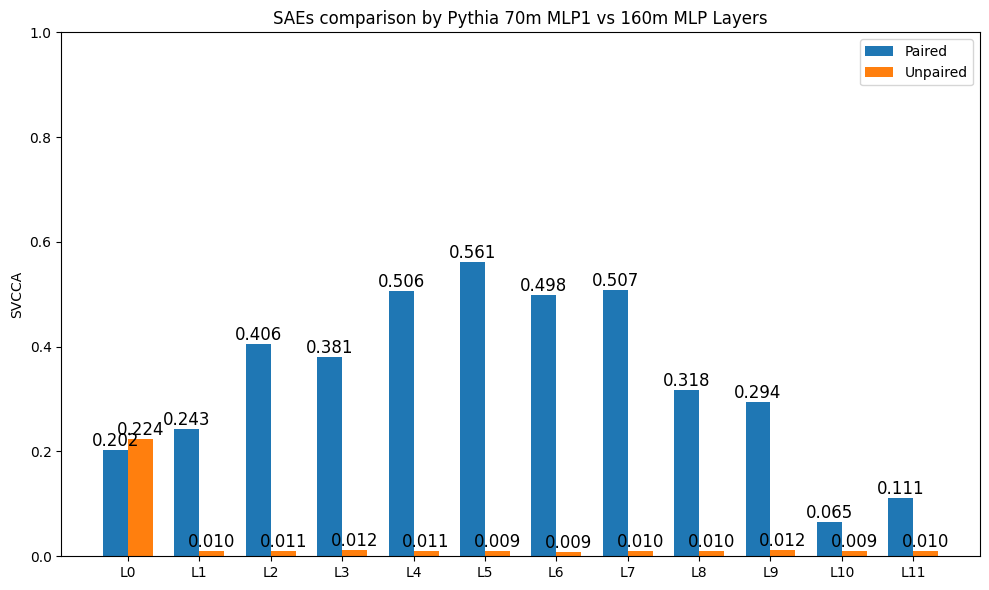

In [43]:
plot_svcca_byLayer(layer_to_dictscores)

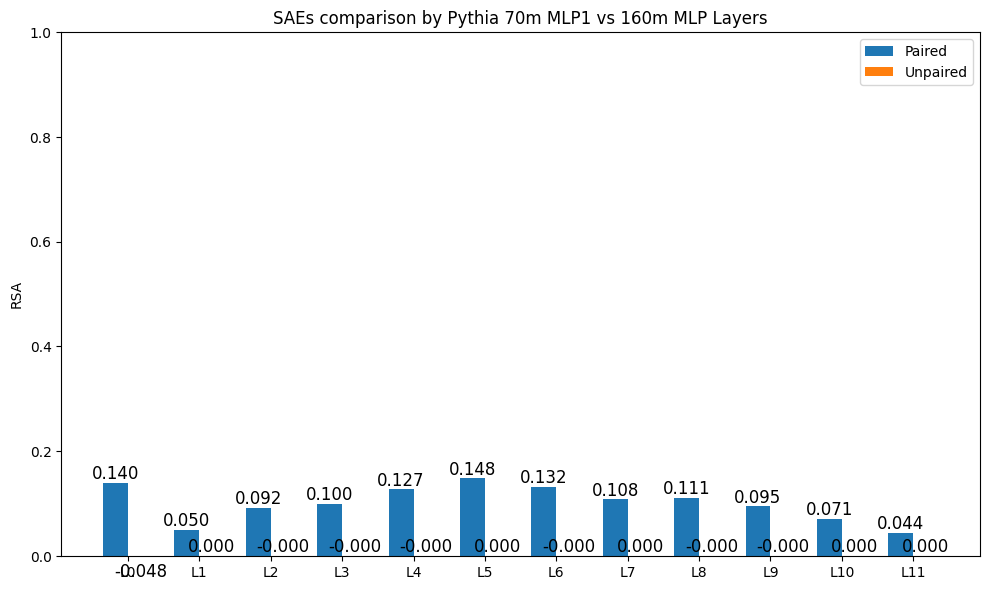

In [44]:
plot_rsa_byLayer(layer_to_dictscores)

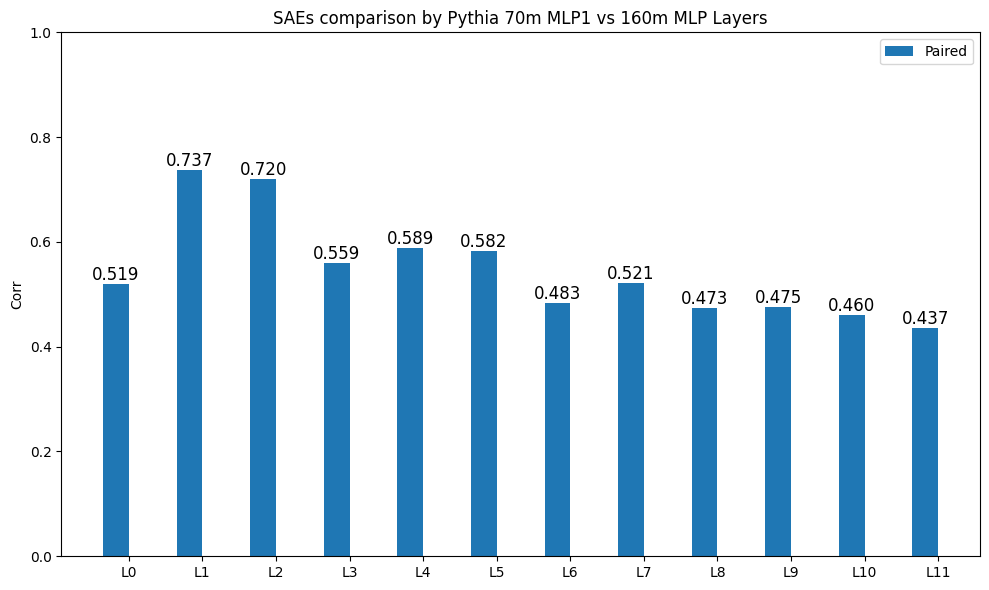

In [45]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

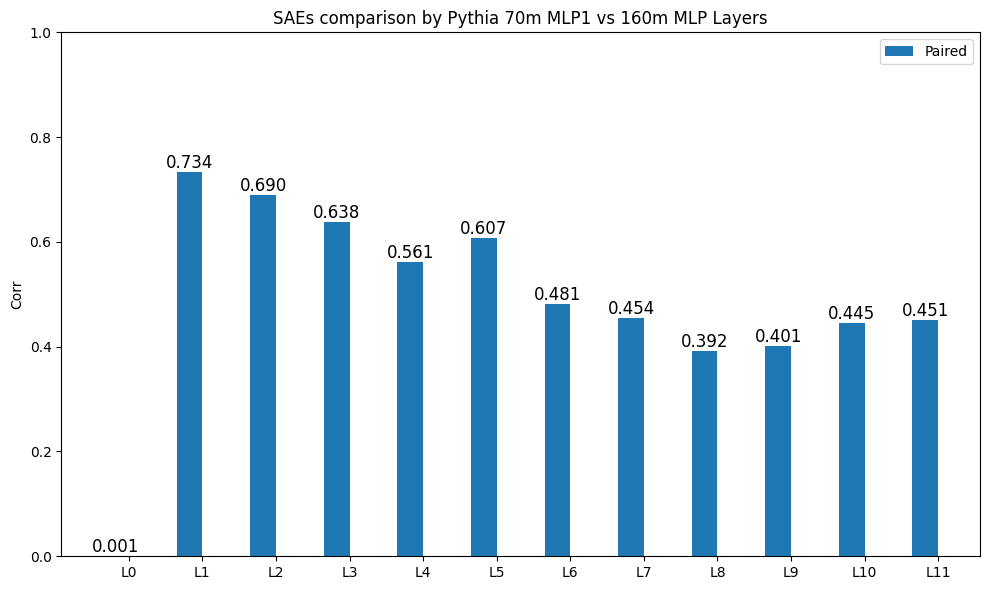

In [46]:
plot_meanCorr_byLayer(layer_to_dictscores)

In [47]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_kept'])

0 12
1 7553
2 6987
3 4025
4 6640
5 5050
6 5718
7 7012
8 6656
9 6193
10 4987
11 3599


In [48]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_A_unique'])

0 12
1 7553
2 6987
3 4025
4 6640
5 5050
6 5718
7 7012
8 6656
9 6193
10 4987
11 3599


# Model A, L2

In [49]:
layer_id = 2

with torch.inference_mode():
    outputs = get_llm_actvs_batch(model, inputs, layer_id, batch_size=100, maxseqlen=300)

In [50]:
layer_start = 0
layer_end = len(model_2.gpt_neox.layers)
layer_to_dictscores = run_expm(layer_id, outputs, outputs_2, layer_start, layer_end)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.000457763671875
num feats after filt:  15
% unique:  1.0
num feats after 1-1:  15
% unique after rmv 0s:  0.000457763671875
num feats after rmv 0s:  15
svcca paired done
rsa paired done
Layer: 0
mean_actv_corr: 0.000669304062057563
num_feat_kept: 15
num_feat_A_unique: 15
mean_actv_corr_filt: 0.4918799728155136
svcca_paired: 0.281453787425339
svcca_rand_mean: 0.1813157182612864
svcca_rand_pval: 0.25
rsa_paired: 0.15316193240721543
rsa_rand_mean: 0.05103410740203194
rsa_rand_pval: 0.15




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.154083251953125
num feats after filt:  21425
% unique:  1.0
num feats after 1-1:  5049
% unique after rmv 0s:  0.154083251953125
num feats after rmv 0s:  5049
svcca paired done
rsa paired done
Layer: 1
mean_actv_corr: 0.6842851163848991
num_feat_kept: 5049
num_feat_A_unique: 5049
mean_actv_corr_filt: 0.6811050338012838
svcca_paired: 0.1897804439733897
svcca_rand_mean: 0.00949975756042079
svcca_rand_pval: 0.0
rsa_paired: 0.04827274910927318
rsa_rand_mean: -0.0010011560264173308
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.150604248046875
num feats after filt:  14201
% unique:  1.0
num feats after 1-1:  4935
% unique after rmv 0s:  0.150604248046875
num feats after rmv 0s:  4935
svcca paired done
rsa paired done
Layer: 2
mean_actv_corr: 0.6951166221194853
num_feat_kept: 4935
num_feat_A_unique: 4935
mean_actv_corr_filt: 0.679743577062842
svcca_paired: 0.39763610722999626
svcca_rand_mean: 0.012875234938702152
svcca_rand_pval: 0.0
rsa_paired: 0.10323205683019816
rsa_rand_mean: -0.0009717308050181906
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.09619140625
num feats after filt:  7788
% unique:  1.0
num feats after 1-1:  3152
% unique after rmv 0s:  0.09619140625
num feats after rmv 0s:  3152
svcca paired done
rsa paired done
Layer: 3
mean_actv_corr: 0.7650287390695212
num_feat_kept: 3152
num_feat_A_unique: 3152
mean_actv_corr_filt: 0.5637133971665074
svcca_paired: 0.34845414089170185
svcca_rand_mean: 0.01170739286899571
svcca_rand_pval: 0.0
rsa_paired: 0.11002849701138158
rsa_rand_mean: 0.00037094001383149264
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.1544189453125
num feats after filt:  11207
% unique:  1.0
num feats after 1-1:  5060
% unique after rmv 0s:  0.154205322265625
num feats after rmv 0s:  5053
svcca paired done
rsa paired done
Layer: 4
mean_actv_corr: 0.6040481330391003
num_feat_kept: 5053
num_feat_A_unique: 5053
mean_actv_corr_filt: 0.5844771569270722
svcca_paired: 0.5698969418236177
svcca_rand_mean: 0.009898573094645003
svcca_rand_pval: 0.0
rsa_paired: 0.1889633678780172
rsa_rand_mean: -4.766451293723692e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.12396240234375
num feats after filt:  6838
% unique:  1.0
num feats after 1-1:  4062
% unique after rmv 0s:  0.123748779296875
num feats after rmv 0s:  4055
svcca paired done
rsa paired done
Layer: 5
mean_actv_corr: 0.6979668723586201
num_feat_kept: 4055
num_feat_A_unique: 4055
mean_actv_corr_filt: 0.5943066550021401
svcca_paired: 0.6782026472858981
svcca_rand_mean: 0.010903683748361174
svcca_rand_pval: 0.0
rsa_paired: 0.20709602339416538
rsa_rand_mean: -0.000411190120838174
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.138275146484375
num feats after filt:  9596
% unique:  1.0
num feats after 1-1:  4531
% unique after rmv 0s:  0.13800048828125
num feats after rmv 0s:  4522
svcca paired done
rsa paired done
Layer: 6
mean_actv_corr: 0.5508694723619101
num_feat_kept: 4522
num_feat_A_unique: 4522
mean_actv_corr_filt: 0.49354312978009374
svcca_paired: 0.5997382434453771
svcca_rand_mean: 0.00957193286432095
svcca_rand_pval: 0.0
rsa_paired: 0.17587330703659393
rsa_rand_mean: -0.0009531073215666277
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.1729736328125
num feats after filt:  13027
% unique:  1.0
num feats after 1-1:  5668
% unique after rmv 0s:  0.172576904296875
num feats after rmv 0s:  5655
svcca paired done
rsa paired done
Layer: 7
mean_actv_corr: 0.4918369912163598
num_feat_kept: 5655
num_feat_A_unique: 5655
mean_actv_corr_filt: 0.535280214045872
svcca_paired: 0.622819451141089
svcca_rand_mean: 0.0093860984030425
svcca_rand_pval: 0.0
rsa_paired: 0.15270192475800254
rsa_rand_mean: 5.0379611611616163e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.158355712890625
num feats after filt:  12649
% unique:  1.0
num feats after 1-1:  5189
% unique after rmv 0s:  0.15771484375
num feats after rmv 0s:  5168
svcca paired done
rsa paired done
Layer: 8
mean_actv_corr: 0.4228791839478845
num_feat_kept: 5168
num_feat_A_unique: 5168
mean_actv_corr_filt: 0.4882330534051262
svcca_paired: 0.38410006966284915
svcca_rand_mean: 0.008865440392190114
svcca_rand_pval: 0.0
rsa_paired: 0.16350837694601367
rsa_rand_mean: -0.0002903690978773477
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.14715576171875
num feats after filt:  11989
% unique:  1.0
num feats after 1-1:  4822
% unique after rmv 0s:  0.146820068359375
num feats after rmv 0s:  4811
svcca paired done
rsa paired done
Layer: 9
mean_actv_corr: 0.46057377309182357
num_feat_kept: 4811
num_feat_A_unique: 4811
mean_actv_corr_filt: 0.49213219523999774
svcca_paired: 0.29896890374230545
svcca_rand_mean: 0.009335356489987534
svcca_rand_pval: 0.0
rsa_paired: 0.1332918640879208
rsa_rand_mean: -0.0004800448372967709
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.118072509765625
num feats after filt:  8616
% unique:  1.0
num feats after 1-1:  3869
% unique after rmv 0s:  0.117431640625
num feats after rmv 0s:  3848
svcca paired done
rsa paired done
Layer: 10
mean_actv_corr: 0.519898136484926
num_feat_kept: 3848
num_feat_A_unique: 3848
mean_actv_corr_filt: 0.4737020721717151
svcca_paired: 0.14453574571849082
svcca_rand_mean: 0.014017806653985729
svcca_rand_pval: 0.0
rsa_paired: 0.10444739675571936
rsa_rand_mean: -0.00014402803209494008
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.08709716796875
num feats after filt:  6623
% unique:  1.0
num feats after 1-1:  2854
% unique after rmv 0s:  0.085968017578125
num feats after rmv 0s:  2817
svcca paired done
rsa paired done
Layer: 11
mean_actv_corr: 0.5607534798108986
num_feat_kept: 2817
num_feat_A_unique: 2817
mean_actv_corr_filt: 0.4587938980796805
svcca_paired: 0.18886278741654572
svcca_rand_mean: 0.010590068547999026
svcca_rand_pval: 0.0
rsa_paired: 0.07078691423553772
rsa_rand_mean: -0.0002426026555827629
rsa_rand_pval: 0.0




In [51]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.000669304062057563,
  'num_feat_kept': 15,
  'num_feat_A_unique': 15,
  'mean_actv_corr_filt': 0.4918799728155136,
  'svcca_paired': 0.281453787425339,
  'svcca_rand_mean': 0.1813157182612864,
  'svcca_rand_pval': 0.25,
  'rsa_paired': 0.15316193240721543,
  'rsa_rand_mean': 0.05103410740203194,
  'rsa_rand_pval': 0.15},
 1: {'mean_actv_corr': 0.6842851163848991,
  'num_feat_kept': 5049,
  'num_feat_A_unique': 5049,
  'mean_actv_corr_filt': 0.6811050338012838,
  'svcca_paired': 0.1897804439733897,
  'svcca_rand_mean': 0.00949975756042079,
  'svcca_rand_pval': 0.0,
  'rsa_paired': 0.04827274910927318,
  'rsa_rand_mean': -0.0010011560264173308,
  'rsa_rand_pval': 0.0},
 2: {'mean_actv_corr': 0.6951166221194853,
  'num_feat_kept': 4935,
  'num_feat_A_unique': 4935,
  'mean_actv_corr_filt': 0.679743577062842,
  'svcca_paired': 0.39763610722999626,
  'svcca_rand_mean': 0.012875234938702152,
  'svcca_rand_pval': 0.0,
  'rsa_paired': 0.10323205683019816,
  'rsa_rand_m

In [52]:
layer_id = 2

In [53]:
with open(f'pythia70m_L{layer_id}_pythia160m_multL.pkl', 'wb') as f:
    pickle.dump(layer_to_dictscores, f)
files.download(f'pythia70m_L{layer_id}_pythia160m_multL.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### plot

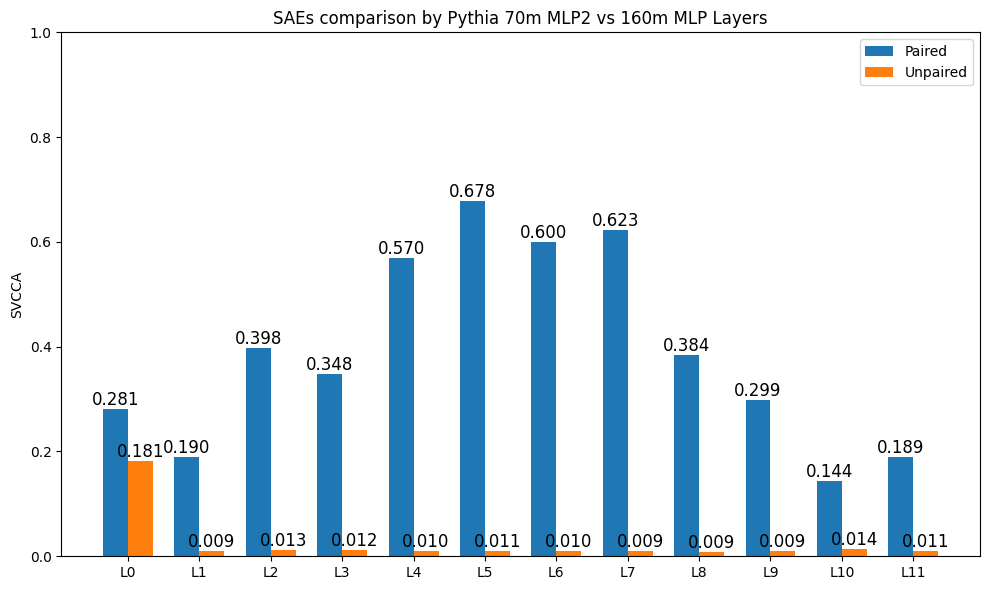

In [54]:
plot_svcca_byLayer(layer_to_dictscores)

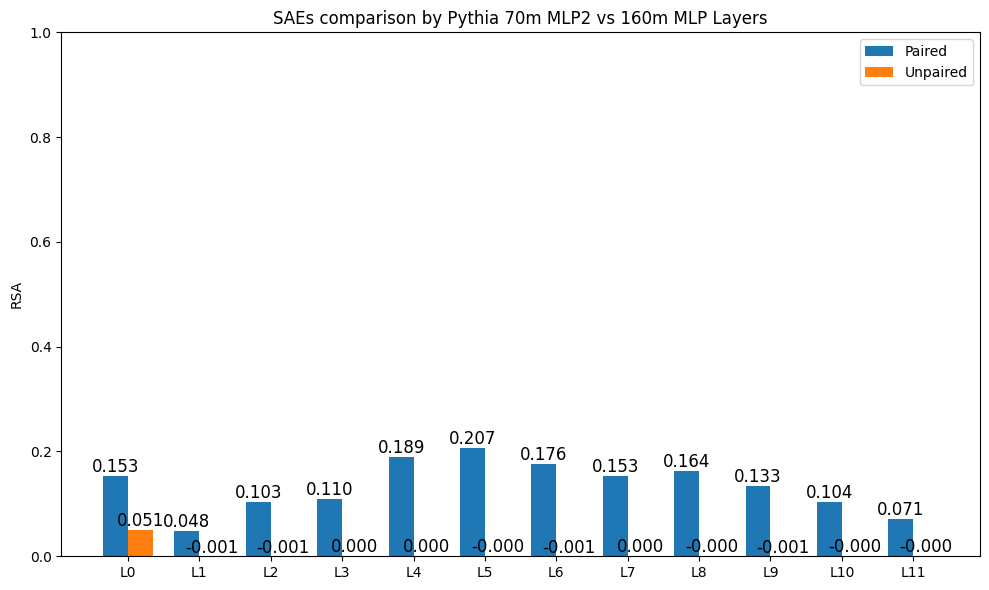

In [55]:
plot_rsa_byLayer(layer_to_dictscores)

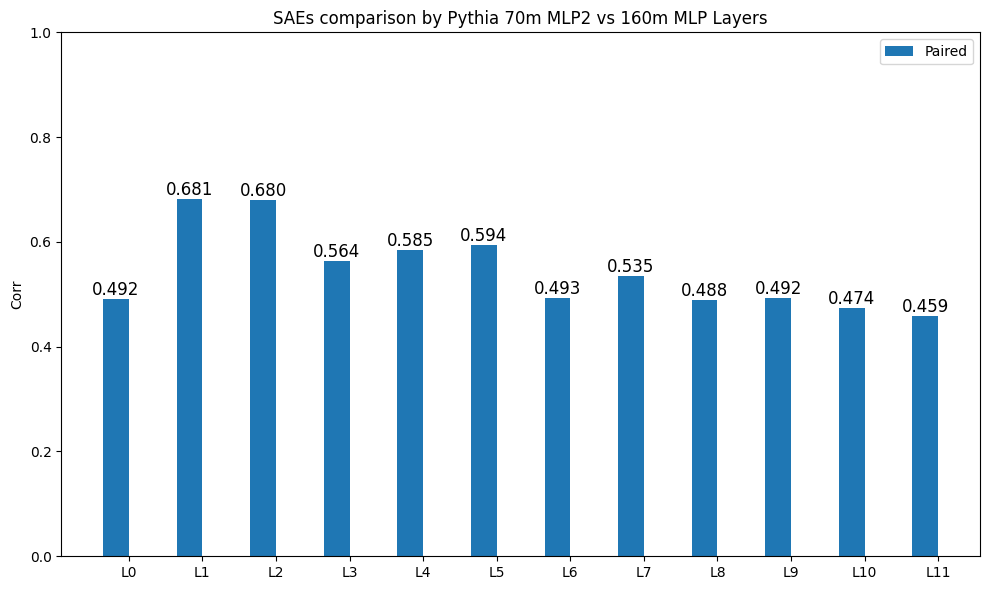

In [56]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

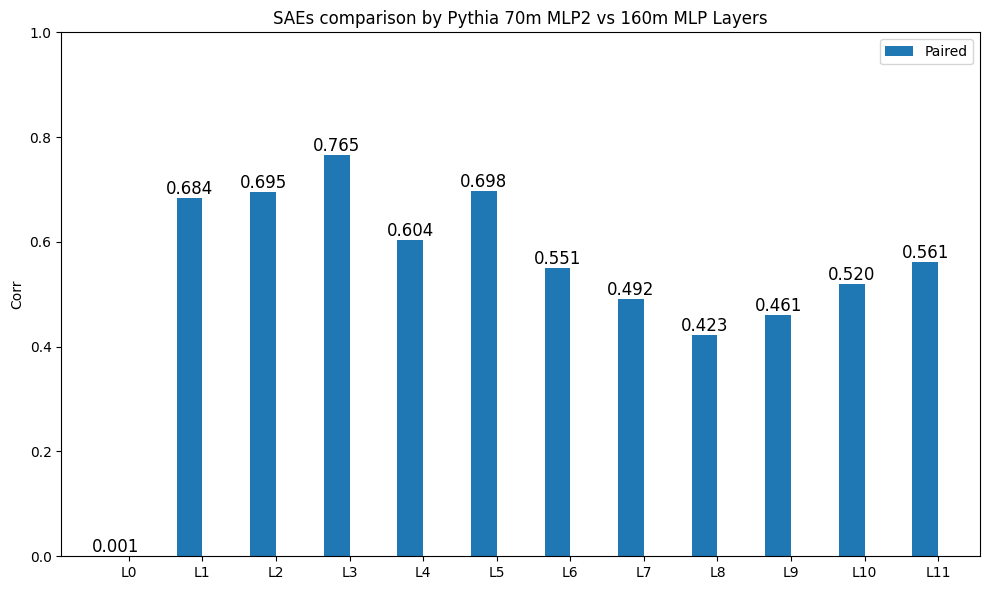

In [57]:
plot_meanCorr_byLayer(layer_to_dictscores)

In [58]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_kept'])

0 15
1 5049
2 4935
3 3152
4 5053
5 4055
6 4522
7 5655
8 5168
9 4811
10 3848
11 2817


In [59]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_A_unique'])

0 15
1 5049
2 4935
3 3152
4 5053
5 4055
6 4522
7 5655
8 5168
9 4811
10 3848
11 2817


# Model A, L3

In [60]:
layer_id = 3

with torch.inference_mode():
    outputs = get_llm_actvs_batch(model, inputs, layer_id, batch_size=100, maxseqlen=300)

In [61]:
layer_start = 0
layer_end = len(model_2.gpt_neox.layers)
layer_to_dictscores = run_expm(layer_id, outputs, outputs_2, layer_start, layer_end)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.00030517578125
num feats after filt:  10
% unique:  1.0
num feats after 1-1:  10
% unique after rmv 0s:  0.00030517578125
num feats after rmv 0s:  10
svcca paired done
rsa paired done
Layer: 0
mean_actv_corr: 0.0006405744341009267
num_feat_kept: 10
num_feat_A_unique: 10
mean_actv_corr_filt: 0.5033418148756027
svcca_paired: 0.09548641412974
svcca_rand_mean: 0.2841866613114087
svcca_rand_pval: 0.8
rsa_paired: -0.11686429512516468
rsa_rand_mean: -0.012173913043478255
rsa_rand_pval: 0.65




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.178619384765625
num feats after filt:  26578
% unique:  1.0
num feats after 1-1:  5853
% unique after rmv 0s:  0.178619384765625
num feats after rmv 0s:  5853
svcca paired done
rsa paired done
Layer: 1
mean_actv_corr: 0.6305716291244607
num_feat_kept: 5853
num_feat_A_unique: 5853
mean_actv_corr_filt: 0.6192953022903058
svcca_paired: 0.15529835310832757
svcca_rand_mean: 0.009304009448887086
svcca_rand_pval: 0.0
rsa_paired: 0.036670640557546375
rsa_rand_mean: -5.092864163715664e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.172821044921875
num feats after filt:  17578
% unique:  1.0
num feats after 1-1:  5663
% unique after rmv 0s:  0.172821044921875
num feats after rmv 0s:  5663
svcca paired done
rsa paired done
Layer: 2
mean_actv_corr: 0.6577111429078286
num_feat_kept: 5663
num_feat_A_unique: 5663
mean_actv_corr_filt: 0.6232891555269678
svcca_paired: 0.33962383673422064
svcca_rand_mean: 0.011653742187196389
svcca_rand_pval: 0.0
rsa_paired: 0.08847857198515517
rsa_rand_mean: 0.0003230946051728141
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.098419189453125
num feats after filt:  7841
% unique:  1.0
num feats after 1-1:  3225
% unique after rmv 0s:  0.098419189453125
num feats after rmv 0s:  3225
svcca paired done
rsa paired done
Layer: 3
mean_actv_corr: 0.748211615720038
num_feat_kept: 3225
num_feat_A_unique: 3225
mean_actv_corr_filt: 0.5217588573578716
svcca_paired: 0.24428425050289948
svcca_rand_mean: 0.016560817280796045
svcca_rand_pval: 0.0
rsa_paired: 0.11064379670798674
rsa_rand_mean: 0.0003751002471538166
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.183563232421875
num feats after filt:  13349
% unique:  1.0
num feats after 1-1:  6015
% unique after rmv 0s:  0.183563232421875
num feats after rmv 0s:  6015
svcca paired done
rsa paired done
Layer: 4
mean_actv_corr: 0.5970851329386733
num_feat_kept: 6015
num_feat_A_unique: 6015
mean_actv_corr_filt: 0.5460304165644538
svcca_paired: 0.5211553108111635
svcca_rand_mean: 0.010489424693761212
svcca_rand_pval: 0.0
rsa_paired: 0.18011621293220742
rsa_rand_mean: 1.9186716562723622e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.1463623046875
num feats after filt:  8175
% unique:  1.0
num feats after 1-1:  4796
% unique after rmv 0s:  0.146270751953125
num feats after rmv 0s:  4793
svcca paired done
rsa paired done
Layer: 5
mean_actv_corr: 0.6982761515196216
num_feat_kept: 4793
num_feat_A_unique: 4793
mean_actv_corr_filt: 0.5523868829273069
svcca_paired: 0.6609927722091464
svcca_rand_mean: 0.01414172690128861
svcca_rand_pval: 0.0
rsa_paired: 0.19977423192221866
rsa_rand_mean: -0.00011376947572584763
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.159637451171875
num feats after filt:  10938
% unique:  1.0
num feats after 1-1:  5231
% unique after rmv 0s:  0.15960693359375
num feats after rmv 0s:  5230
svcca paired done
rsa paired done
Layer: 6
mean_actv_corr: 0.5504689849290116
num_feat_kept: 5230
num_feat_A_unique: 5230
mean_actv_corr_filt: 0.4728534631388365
svcca_paired: 0.6333334329232643
svcca_rand_mean: 0.008266091329491201
svcca_rand_pval: 0.0
rsa_paired: 0.20113925184577924
rsa_rand_mean: 0.0005595388820853471
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.2064208984375
num feats after filt:  16333
% unique:  1.0
num feats after 1-1:  6764
% unique after rmv 0s:  0.206298828125
num feats after rmv 0s:  6760
svcca paired done
rsa paired done
Layer: 7
mean_actv_corr: 0.48257152686414884
num_feat_kept: 6760
num_feat_A_unique: 6760
mean_actv_corr_filt: 0.505984853383308
svcca_paired: 0.6489905112735814
svcca_rand_mean: 0.0089699483463677
svcca_rand_pval: 0.0
rsa_paired: 0.17298784654166632
rsa_rand_mean: 9.658083281472869e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.19305419921875
num feats after filt:  15316
% unique:  1.0
num feats after 1-1:  6326
% unique after rmv 0s:  0.19281005859375
num feats after rmv 0s:  6318
svcca paired done
rsa paired done
Layer: 8
mean_actv_corr: 0.4193798672461071
num_feat_kept: 6318
num_feat_A_unique: 6318
mean_actv_corr_filt: 0.4640620696043225
svcca_paired: 0.5405245087843298
svcca_rand_mean: 0.007620512519490956
svcca_rand_pval: 0.0
rsa_paired: 0.1829542725736507
rsa_rand_mean: 0.0004914897453612284
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.1763916015625
num feats after filt:  14358
% unique:  1.0
num feats after 1-1:  5780
% unique after rmv 0s:  0.17608642578125
num feats after rmv 0s:  5770
svcca paired done
rsa paired done
Layer: 9
mean_actv_corr: 0.45468790880272536
num_feat_kept: 5770
num_feat_A_unique: 5770
mean_actv_corr_filt: 0.47080972274213356
svcca_paired: 0.5088986023757059
svcca_rand_mean: 0.009048187108182525
svcca_rand_pval: 0.0
rsa_paired: 0.16374915248998936
rsa_rand_mean: 0.00012521451530451833
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.140594482421875
num feats after filt:  9752
% unique:  1.0
num feats after 1-1:  4607
% unique after rmv 0s:  0.140411376953125
num feats after rmv 0s:  4601
svcca paired done
rsa paired done
Layer: 10
mean_actv_corr: 0.5205300880402319
num_feat_kept: 4601
num_feat_A_unique: 4601
mean_actv_corr_filt: 0.4610873688837415
svcca_paired: 0.20572701408471855
svcca_rand_mean: 0.012688306636667621
svcca_rand_pval: 0.0
rsa_paired: 0.13086490691289088
rsa_rand_mean: 4.738739183903996e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.10321044921875
num feats after filt:  7146
% unique:  1.0
num feats after 1-1:  3382
% unique after rmv 0s:  0.102874755859375
num feats after rmv 0s:  3371
svcca paired done
rsa paired done
Layer: 11
mean_actv_corr: 0.559706570498065
num_feat_kept: 3371
num_feat_A_unique: 3371
mean_actv_corr_filt: 0.445324139013661
svcca_paired: 0.1976484110817214
svcca_rand_mean: 0.012386149640672351
svcca_rand_pval: 0.0
rsa_paired: 0.09340194453317681
rsa_rand_mean: 5.895866481168418e-05
rsa_rand_pval: 0.0




In [62]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.0006405744341009267,
  'num_feat_kept': 10,
  'num_feat_A_unique': 10,
  'mean_actv_corr_filt': 0.5033418148756027,
  'svcca_paired': 0.09548641412974,
  'svcca_rand_mean': 0.2841866613114087,
  'svcca_rand_pval': 0.8,
  'rsa_paired': -0.11686429512516468,
  'rsa_rand_mean': -0.012173913043478255,
  'rsa_rand_pval': 0.65},
 1: {'mean_actv_corr': 0.6305716291244607,
  'num_feat_kept': 5853,
  'num_feat_A_unique': 5853,
  'mean_actv_corr_filt': 0.6192953022903058,
  'svcca_paired': 0.15529835310832757,
  'svcca_rand_mean': 0.009304009448887086,
  'svcca_rand_pval': 0.0,
  'rsa_paired': 0.036670640557546375,
  'rsa_rand_mean': -5.092864163715664e-05,
  'rsa_rand_pval': 0.0},
 2: {'mean_actv_corr': 0.6577111429078286,
  'num_feat_kept': 5663,
  'num_feat_A_unique': 5663,
  'mean_actv_corr_filt': 0.6232891555269678,
  'svcca_paired': 0.33962383673422064,
  'svcca_rand_mean': 0.011653742187196389,
  'svcca_rand_pval': 0.0,
  'rsa_paired': 0.08847857198515517,
  'rsa_

In [63]:
with open(f'pythia70m_L{layer_id}_pythia160m_multL.pkl', 'wb') as f:
    pickle.dump(layer_to_dictscores, f)
files.download(f'pythia70m_L{layer_id}_pythia160m_multL.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### plot

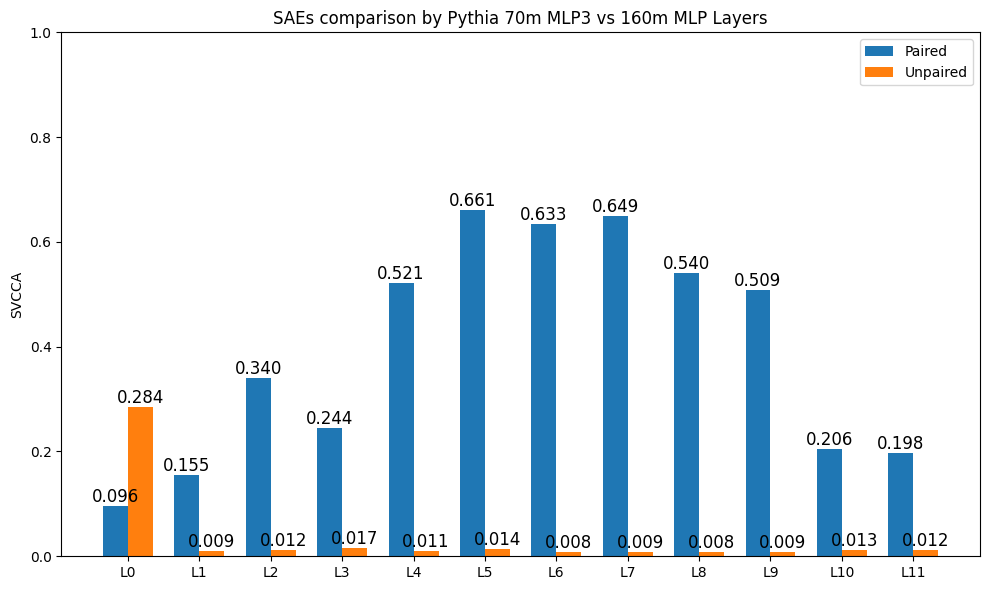

In [64]:
plot_svcca_byLayer(layer_to_dictscores)

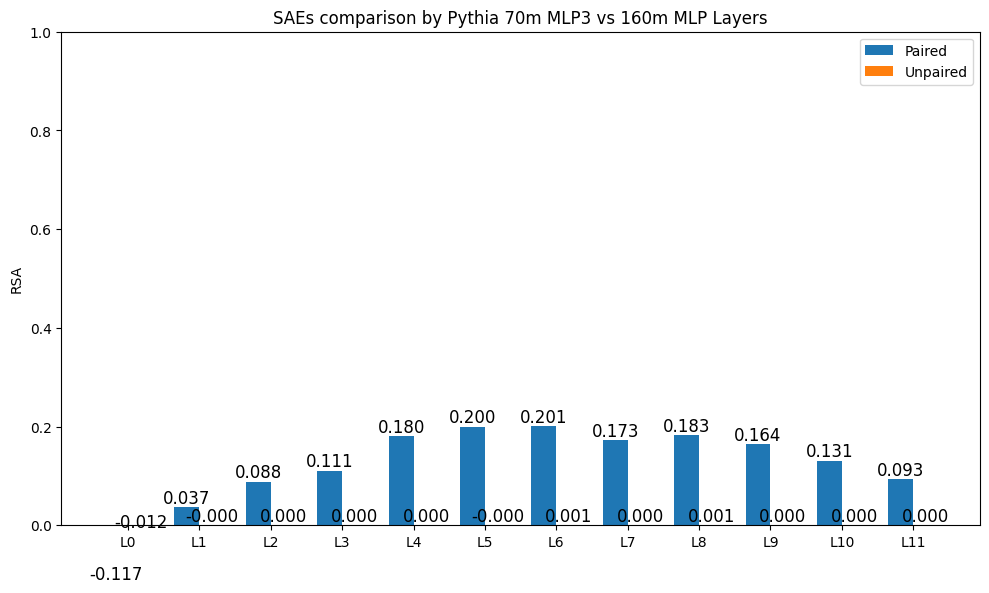

In [65]:
plot_rsa_byLayer(layer_to_dictscores)

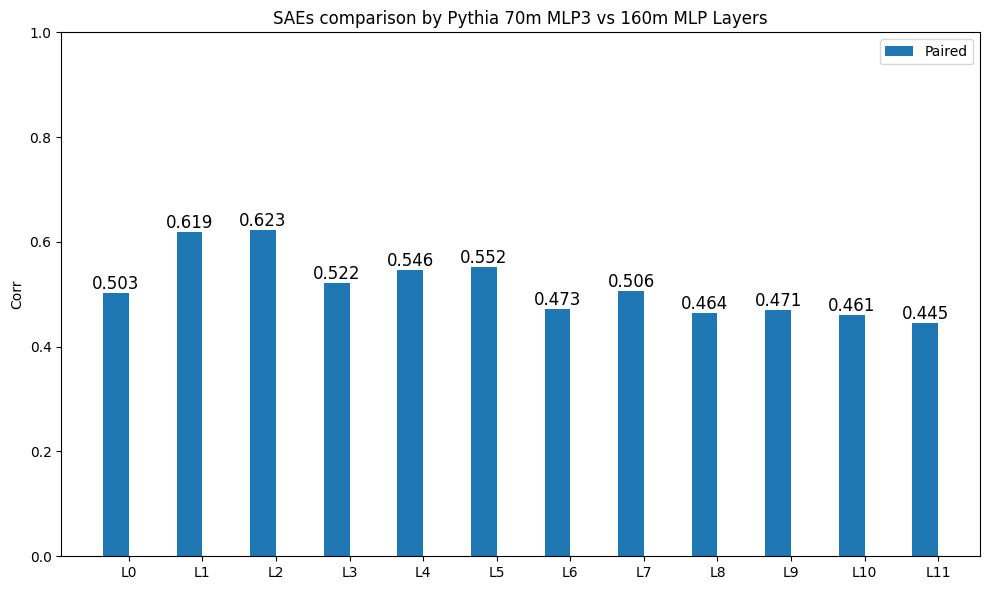

In [66]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

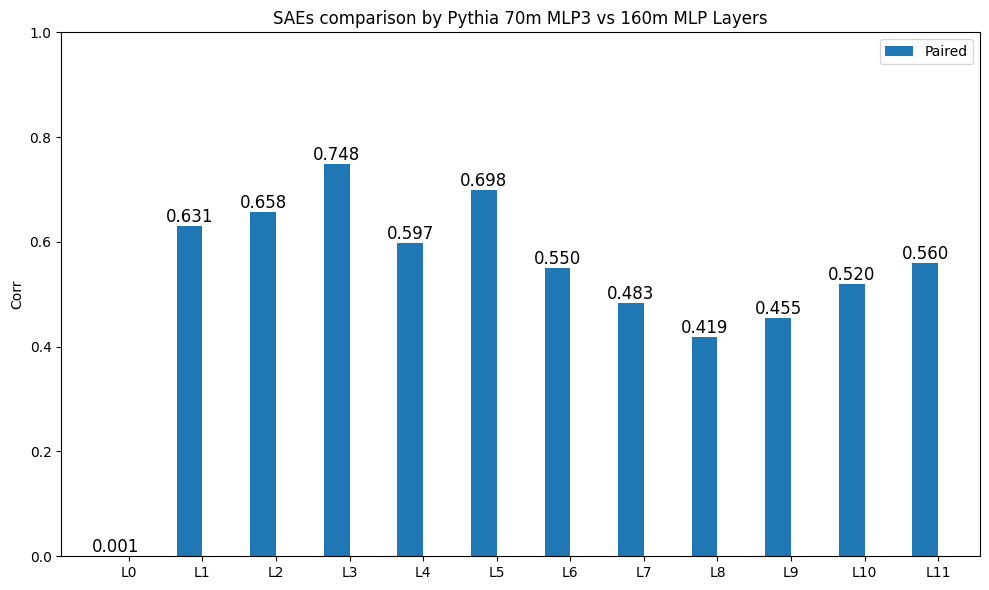

In [67]:
plot_meanCorr_byLayer(layer_to_dictscores)

In [68]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_kept'])

0 10
1 5853
2 5663
3 3225
4 6015
5 4793
6 5230
7 6760
8 6318
9 5770
10 4601
11 3371


In [69]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_A_unique'])

0 10
1 5853
2 5663
3 3225
4 6015
5 4793
6 5230
7 6760
8 6318
9 5770
10 4601
11 3371


# Model A, L4

In [70]:
layer_id = 4

with torch.inference_mode():
    outputs = get_llm_actvs_batch(model, inputs, layer_id, batch_size=100, maxseqlen=300)

In [71]:
layer_start = 0
layer_end = len(model_2.gpt_neox.layers)
layer_to_dictscores = run_expm(layer_id, outputs, outputs_2, layer_start, layer_end)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.00018310546875
num feats after filt:  6
% unique:  1.0
num feats after 1-1:  6
% unique after rmv 0s:  0.00018310546875
num feats after rmv 0s:  6
svcca paired done
rsa paired done
Layer: 0
mean_actv_corr: 0.0003840677338757814
num_feat_kept: 6
num_feat_A_unique: 6
mean_actv_corr_filt: 0.2675948068499565
svcca_paired: 0.3937525851948807
svcca_rand_mean: 0.4460403424151333
svcca_rand_pval: 0.65
rsa_paired: -0.3607142857142856
rsa_rand_mean: 0.10339285714285713
rsa_rand_pval: 0.95




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.101715087890625
num feats after filt:  20221
% unique:  1.0
num feats after 1-1:  3333
% unique after rmv 0s:  0.09698486328125
num feats after rmv 0s:  3178
svcca paired done
rsa paired done
Layer: 1
mean_actv_corr: 0.2757306397533057
num_feat_kept: 3178
num_feat_A_unique: 3178
mean_actv_corr_filt: 0.2809213284260076
svcca_paired: 0.02843919529299019
svcca_rand_mean: 0.015842685583970333
svcca_rand_pval: 0.2
rsa_paired: 0.012563083431015467
rsa_rand_mean: 9.560264718409879e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.09979248046875
num feats after filt:  13106
% unique:  1.0
num feats after 1-1:  3270
% unique after rmv 0s:  0.096832275390625
num feats after rmv 0s:  3173
svcca paired done
rsa paired done
Layer: 2
mean_actv_corr: 0.43549517411690886
num_feat_kept: 3173
num_feat_A_unique: 3173
mean_actv_corr_filt: 0.29892992094192
svcca_paired: 0.16380206993123506
svcca_rand_mean: 0.017861783051494565
svcca_rand_pval: 0.0
rsa_paired: 0.032219977900477065
rsa_rand_mean: 0.000613938833054394
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.067230224609375
num feats after filt:  7061
% unique:  1.0
num feats after 1-1:  2203
% unique after rmv 0s:  0.066162109375
num feats after rmv 0s:  2168
svcca paired done
rsa paired done
Layer: 3
mean_actv_corr: 0.7320115486215855
num_feat_kept: 2168
num_feat_A_unique: 2168
mean_actv_corr_filt: 0.41664297922730886
svcca_paired: 0.12890181730250336
svcca_rand_mean: 0.017450390008897823
svcca_rand_pval: 0.0
rsa_paired: 0.03730056715207588
rsa_rand_mean: 6.592748927133595e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.100006103515625
num feats after filt:  9344
% unique:  1.0
num feats after 1-1:  3277
% unique after rmv 0s:  0.095611572265625
num feats after rmv 0s:  3133
svcca paired done
rsa paired done
Layer: 4
mean_actv_corr: 0.47834176265905626
num_feat_kept: 3133
num_feat_A_unique: 3133
mean_actv_corr_filt: 0.3011230583859449
svcca_paired: 0.19230898990747236
svcca_rand_mean: 0.016412918885697837
svcca_rand_pval: 0.0
rsa_paired: 0.06480644451607753
rsa_rand_mean: -1.286999368035047e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.07928466796875
num feats after filt:  5519
% unique:  1.0
num feats after 1-1:  2598
% unique after rmv 0s:  0.07647705078125
num feats after rmv 0s:  2506
svcca paired done
rsa paired done
Layer: 5
mean_actv_corr: 0.642711179455091
num_feat_kept: 2506
num_feat_A_unique: 2506
mean_actv_corr_filt: 0.34055621593786256
svcca_paired: 0.2630201289673087
svcca_rand_mean: 0.013738562724083109
svcca_rand_pval: 0.0
rsa_paired: 0.06891601123914043
rsa_rand_mean: 8.603854940590123e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.09954833984375
num feats after filt:  8224
% unique:  1.0
num feats after 1-1:  3262
% unique after rmv 0s:  0.097686767578125
num feats after rmv 0s:  3201
svcca paired done
rsa paired done
Layer: 6
mean_actv_corr: 0.5000302130310956
num_feat_kept: 3201
num_feat_A_unique: 3201
mean_actv_corr_filt: 0.31505260374705446
svcca_paired: 0.3177688412073801
svcca_rand_mean: 0.013458296070025879
svcca_rand_pval: 0.0
rsa_paired: 0.06712088974732265
rsa_rand_mean: -0.00025690513862846524
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.125457763671875
num feats after filt:  13126
% unique:  1.0
num feats after 1-1:  4111
% unique after rmv 0s:  0.120452880859375
num feats after rmv 0s:  3947
svcca paired done
rsa paired done
Layer: 7
mean_actv_corr: 0.36550845958345235
num_feat_kept: 3947
num_feat_A_unique: 3947
mean_actv_corr_filt: 0.29400525879363093
svcca_paired: 0.24604871118632374
svcca_rand_mean: 0.012520504034605062
svcca_rand_pval: 0.0
rsa_paired: 0.06396763090825663
rsa_rand_mean: 0.00040125353440256546
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.121124267578125
num feats after filt:  12172
% unique:  1.0
num feats after 1-1:  3969
% unique after rmv 0s:  0.11651611328125
num feats after rmv 0s:  3818
svcca paired done
rsa paired done
Layer: 8
mean_actv_corr: 0.32219943108680127
num_feat_kept: 3818
num_feat_A_unique: 3818
mean_actv_corr_filt: 0.2890096361050748
svcca_paired: 0.3470726298146806
svcca_rand_mean: 0.015569460816504774
svcca_rand_pval: 0.0
rsa_paired: 0.07964174635208779
rsa_rand_mean: -8.553715718487469e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.11431884765625
num feats after filt:  11676
% unique:  1.0
num feats after 1-1:  3746
% unique after rmv 0s:  0.1103515625
num feats after rmv 0s:  3616
svcca paired done
rsa paired done
Layer: 9
mean_actv_corr: 0.3847978456878991
num_feat_kept: 3616
num_feat_A_unique: 3616
mean_actv_corr_filt: 0.3040095113333216
svcca_paired: 0.3669079931075601
svcca_rand_mean: 0.013189967146360629
svcca_rand_pval: 0.0
rsa_paired: 0.07664226114152543
rsa_rand_mean: -0.00022903596847327542
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.09490966796875
num feats after filt:  8005
% unique:  1.0
num feats after 1-1:  3110
% unique after rmv 0s:  0.092529296875
num feats after rmv 0s:  3032
svcca paired done
rsa paired done
Layer: 10
mean_actv_corr: 0.47249122111327324
num_feat_kept: 3032
num_feat_A_unique: 3032
mean_actv_corr_filt: 0.31314739924523793
svcca_paired: 0.3410364720278614
svcca_rand_mean: 0.014065117415657715
svcca_rand_pval: 0.0
rsa_paired: 0.09086849551368095
rsa_rand_mean: -6.137059987237351e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.072998046875
num feats after filt:  5673
% unique:  1.0
num feats after 1-1:  2392
% unique after rmv 0s:  0.07061767578125
num feats after rmv 0s:  2314
svcca paired done
rsa paired done
Layer: 11
mean_actv_corr: 0.5447233695728073
num_feat_kept: 2314
num_feat_A_unique: 2314
mean_actv_corr_filt: 0.3192926525728344
svcca_paired: 0.3044829647036065
svcca_rand_mean: 0.014668122934647383
svcca_rand_pval: 0.0
rsa_paired: 0.07623486200429823
rsa_rand_mean: 0.00017955427717771742
rsa_rand_pval: 0.0




In [72]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.0003840677338757814,
  'num_feat_kept': 6,
  'num_feat_A_unique': 6,
  'mean_actv_corr_filt': 0.2675948068499565,
  'svcca_paired': 0.3937525851948807,
  'svcca_rand_mean': 0.4460403424151333,
  'svcca_rand_pval': 0.65,
  'rsa_paired': -0.3607142857142856,
  'rsa_rand_mean': 0.10339285714285713,
  'rsa_rand_pval': 0.95},
 1: {'mean_actv_corr': 0.2757306397533057,
  'num_feat_kept': 3178,
  'num_feat_A_unique': 3178,
  'mean_actv_corr_filt': 0.2809213284260076,
  'svcca_paired': 0.02843919529299019,
  'svcca_rand_mean': 0.015842685583970333,
  'svcca_rand_pval': 0.2,
  'rsa_paired': 0.012563083431015467,
  'rsa_rand_mean': 9.560264718409879e-05,
  'rsa_rand_pval': 0.0},
 2: {'mean_actv_corr': 0.43549517411690886,
  'num_feat_kept': 3173,
  'num_feat_A_unique': 3173,
  'mean_actv_corr_filt': 0.29892992094192,
  'svcca_paired': 0.16380206993123506,
  'svcca_rand_mean': 0.017861783051494565,
  'svcca_rand_pval': 0.0,
  'rsa_paired': 0.032219977900477065,
  'rsa_ran

In [73]:
with open(f'pythia70m_L{layer_id}_pythia160m_multL.pkl', 'wb') as f:
    pickle.dump(layer_to_dictscores, f)
files.download(f'pythia70m_L{layer_id}_pythia160m_multL.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### plot

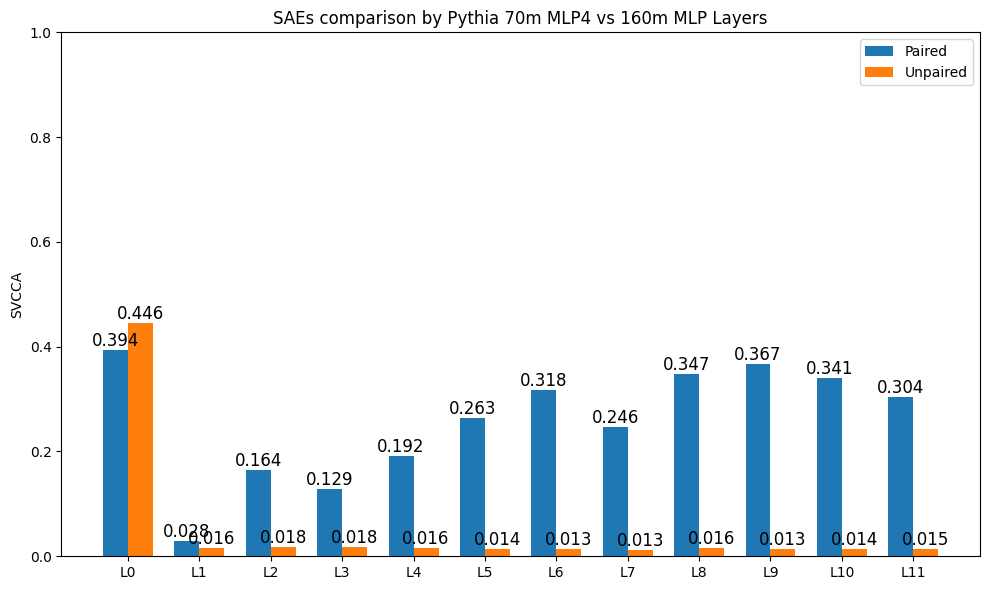

In [74]:
plot_svcca_byLayer(layer_to_dictscores)

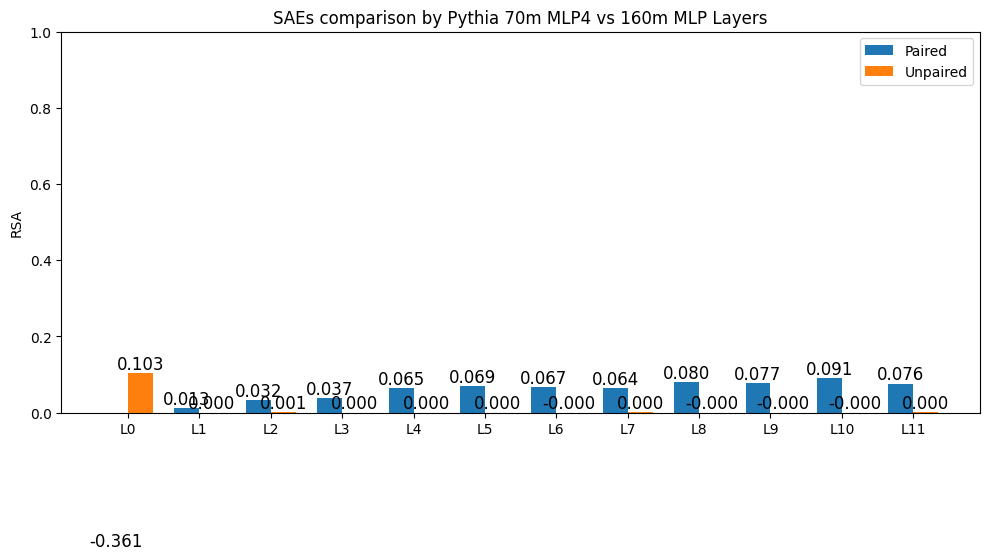

In [75]:
plot_rsa_byLayer(layer_to_dictscores)

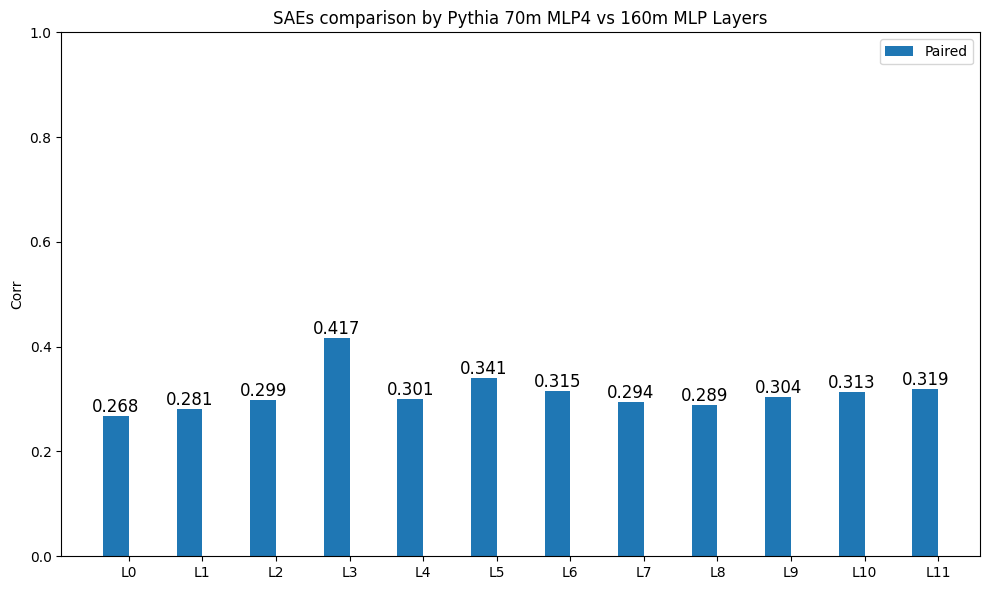

In [76]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

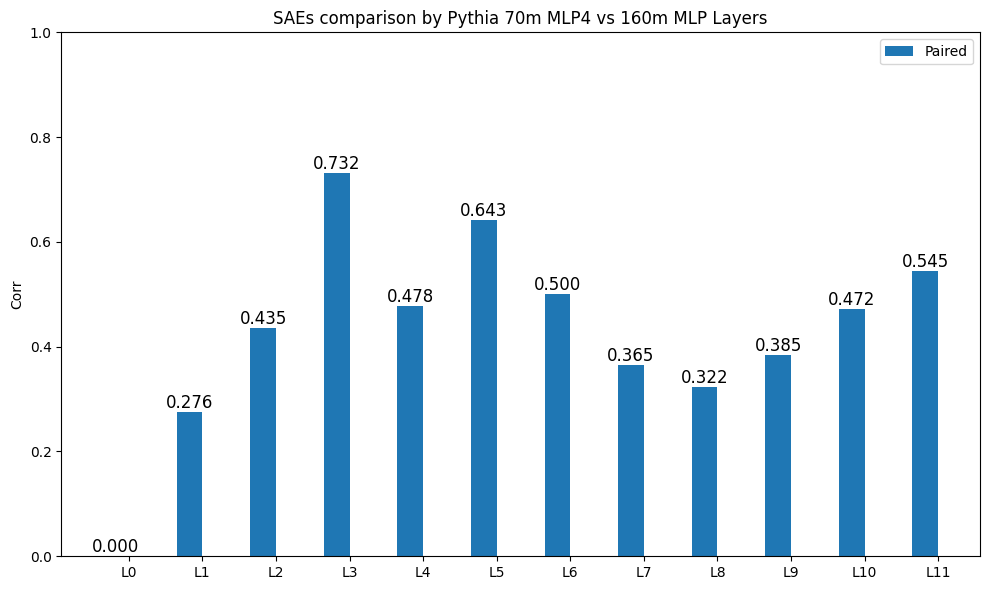

In [77]:
plot_meanCorr_byLayer(layer_to_dictscores)

In [78]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_kept'])

0 6
1 3178
2 3173
3 2168
4 3133
5 2506
6 3201
7 3947
8 3818
9 3616
10 3032
11 2314


In [79]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_A_unique'])

0 6
1 3178
2 3173
3 2168
4 3133
5 2506
6 3201
7 3947
8 3818
9 3616
10 3032
11 2314


# Model A, L5

In [80]:
layer_id = 5

with torch.inference_mode():
    outputs = get_llm_actvs_batch(model, inputs, layer_id, batch_size=100, maxseqlen=300)

In [81]:
layer_start = 0
layer_end = len(model_2.gpt_neox.layers)
layer_to_dictscores = run_expm(layer_id, outputs, outputs_2, layer_start, layer_end)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.000244140625
num feats after filt:  8
% unique:  1.0
num feats after 1-1:  8
% unique after rmv 0s:  0.000244140625
num feats after rmv 0s:  8
svcca paired done
rsa paired done
Layer: 0
mean_actv_corr: 0.00043062663280579727
num_feat_kept: 8
num_feat_A_unique: 8
mean_actv_corr_filt: 0.2957545090466738
svcca_paired: 0.14605972416424867
svcca_rand_mean: 0.20054049273536245
svcca_rand_pval: 0.5
rsa_paired: 0.22933771209633277
rsa_rand_mean: 0.041160372194854945
rsa_rand_pval: 0.2




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.0958251953125
num feats after filt:  19778
% unique:  1.0
num feats after 1-1:  3140
% unique after rmv 0s:  0.093963623046875
num feats after rmv 0s:  3079
svcca paired done
rsa paired done
Layer: 1
mean_actv_corr: 0.3850806389599484
num_feat_kept: 3079
num_feat_A_unique: 3079
mean_actv_corr_filt: 0.4018119042929832
svcca_paired: 0.01113784139333517
svcca_rand_mean: 0.015072329304508057
svcca_rand_pval: 0.5
rsa_paired: 0.011015105596107591
rsa_rand_mean: 0.0001564211645439546
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.094207763671875
num feats after filt:  12866
% unique:  1.0
num feats after 1-1:  3087
% unique after rmv 0s:  0.093017578125
num feats after rmv 0s:  3048
svcca paired done
rsa paired done
Layer: 2
mean_actv_corr: 0.503363070031412
num_feat_kept: 3048
num_feat_A_unique: 3048
mean_actv_corr_filt: 0.4179707038976506
svcca_paired: 0.07761312406151977
svcca_rand_mean: 0.01419246869318332
svcca_rand_pval: 0.0
rsa_paired: 0.02853925231387023
rsa_rand_mean: 8.26741650314264e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.0576171875
num feats after filt:  6638
% unique:  1.0
num feats after 1-1:  1888
% unique after rmv 0s:  0.057342529296875
num feats after rmv 0s:  1879
svcca paired done
rsa paired done
Layer: 3
mean_actv_corr: 0.7384628274261331
num_feat_kept: 1879
num_feat_A_unique: 1879
mean_actv_corr_filt: 0.4224152950457971
svcca_paired: 0.09165468202273121
svcca_rand_mean: 0.016792134183003637
svcca_rand_pval: 0.0
rsa_paired: 0.04285460861476448
rsa_rand_mean: -3.906786273073717e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.097808837890625
num feats after filt:  9456
% unique:  1.0
num feats after 1-1:  3205
% unique after rmv 0s:  0.096435546875
num feats after rmv 0s:  3160
svcca paired done
rsa paired done
Layer: 4
mean_actv_corr: 0.5150216585690259
num_feat_kept: 3160
num_feat_A_unique: 3160
mean_actv_corr_filt: 0.39292019368444064
svcca_paired: 0.06437492231405596
svcca_rand_mean: 0.012609985354786307
svcca_rand_pval: 0.0
rsa_paired: 0.05913228985475005
rsa_rand_mean: 0.00013068818402293906
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.079833984375
num feats after filt:  5695
% unique:  1.0
num feats after 1-1:  2616
% unique after rmv 0s:  0.07855224609375
num feats after rmv 0s:  2574
svcca paired done
rsa paired done
Layer: 5
mean_actv_corr: 0.6621007973395763
num_feat_kept: 2574
num_feat_A_unique: 2574
mean_actv_corr_filt: 0.42092457657684257
svcca_paired: 0.22595073304195823
svcca_rand_mean: 0.018081357593380414
svcca_rand_pval: 0.0
rsa_paired: 0.07754451231114723
rsa_rand_mean: -2.0676348872964632e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.092864990234375
num feats after filt:  8317
% unique:  1.0
num feats after 1-1:  3043
% unique after rmv 0s:  0.0921630859375
num feats after rmv 0s:  3020
svcca paired done
rsa paired done
Layer: 6
mean_actv_corr: 0.5187946035911182
num_feat_kept: 3020
num_feat_A_unique: 3020
mean_actv_corr_filt: 0.3760912450906259
svcca_paired: 0.2899008496084827
svcca_rand_mean: 0.012191498530493245
svcca_rand_pval: 0.0
rsa_paired: 0.07621448878042918
rsa_rand_mean: 0.0001101858582044053
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.118011474609375
num feats after filt:  12925
% unique:  1.0
num feats after 1-1:  3867
% unique after rmv 0s:  0.116912841796875
num feats after rmv 0s:  3831
svcca paired done
rsa paired done
Layer: 7
mean_actv_corr: 0.4100225279901224
num_feat_kept: 3831
num_feat_A_unique: 3831
mean_actv_corr_filt: 0.37916750536905325
svcca_paired: 0.2530995158197887
svcca_rand_mean: 0.011084774361023182
svcca_rand_pval: 0.0
rsa_paired: 0.07110150484324637
rsa_rand_mean: -8.21044594463211e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.116851806640625
num feats after filt:  12007
% unique:  1.0
num feats after 1-1:  3829
% unique after rmv 0s:  0.115753173828125
num feats after rmv 0s:  3793
svcca paired done
rsa paired done
Layer: 8
mean_actv_corr: 0.3630277581264636
num_feat_kept: 3793
num_feat_A_unique: 3793
mean_actv_corr_filt: 0.3513850391779322
svcca_paired: 0.3791622816834198
svcca_rand_mean: 0.015384725377682021
svcca_rand_pval: 0.0
rsa_paired: 0.08231995323397893
rsa_rand_mean: 9.935669287132066e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.112945556640625
num feats after filt:  11497
% unique:  1.0
num feats after 1-1:  3701
% unique after rmv 0s:  0.11199951171875
num feats after rmv 0s:  3670
svcca paired done
rsa paired done
Layer: 9
mean_actv_corr: 0.4214481456887995
num_feat_kept: 3670
num_feat_A_unique: 3670
mean_actv_corr_filt: 0.3755399872906689
svcca_paired: 0.45202605468147106
svcca_rand_mean: 0.01135593685406738
svcca_rand_pval: 0.0
rsa_paired: 0.08837535880684032
rsa_rand_mean: -2.3811860228187232e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.102508544921875
num feats after filt:  8095
% unique:  1.0
num feats after 1-1:  3359
% unique after rmv 0s:  0.10235595703125
num feats after rmv 0s:  3354
svcca paired done
rsa paired done
Layer: 10
mean_actv_corr: 0.511016670112781
num_feat_kept: 3354
num_feat_A_unique: 3354
mean_actv_corr_filt: 0.39562135643159696
svcca_paired: 0.5409735819452528
svcca_rand_mean: 0.009765385367415511
svcca_rand_pval: 0.0
rsa_paired: 0.1068389198321015
rsa_rand_mean: -4.670008941072659e-05
rsa_rand_pval: 0.0




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.082305908203125
num feats after filt:  6051
% unique:  1.0
num feats after 1-1:  2697
% unique after rmv 0s:  0.08203125
num feats after rmv 0s:  2688
svcca paired done
rsa paired done
Layer: 11
mean_actv_corr: 0.578117260773638
num_feat_kept: 2688
num_feat_A_unique: 2688
mean_actv_corr_filt: 0.3931496970139311
svcca_paired: 0.4802822678232746
svcca_rand_mean: 0.01642954952034291
svcca_rand_pval: 0.0
rsa_paired: 0.10985364645996548
rsa_rand_mean: -5.3665300578491617e-05
rsa_rand_pval: 0.0




In [82]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.00043062663280579727,
  'num_feat_kept': 8,
  'num_feat_A_unique': 8,
  'mean_actv_corr_filt': 0.2957545090466738,
  'svcca_paired': 0.14605972416424867,
  'svcca_rand_mean': 0.20054049273536245,
  'svcca_rand_pval': 0.5,
  'rsa_paired': 0.22933771209633277,
  'rsa_rand_mean': 0.041160372194854945,
  'rsa_rand_pval': 0.2},
 1: {'mean_actv_corr': 0.3850806389599484,
  'num_feat_kept': 3079,
  'num_feat_A_unique': 3079,
  'mean_actv_corr_filt': 0.4018119042929832,
  'svcca_paired': 0.01113784139333517,
  'svcca_rand_mean': 0.015072329304508057,
  'svcca_rand_pval': 0.5,
  'rsa_paired': 0.011015105596107591,
  'rsa_rand_mean': 0.0001564211645439546,
  'rsa_rand_pval': 0.0},
 2: {'mean_actv_corr': 0.503363070031412,
  'num_feat_kept': 3048,
  'num_feat_A_unique': 3048,
  'mean_actv_corr_filt': 0.4179707038976506,
  'svcca_paired': 0.07761312406151977,
  'svcca_rand_mean': 0.01419246869318332,
  'svcca_rand_pval': 0.0,
  'rsa_paired': 0.02853925231387023,
  'rsa_ran

In [83]:
with open(f'pythia70m_L{layer_id}_pythia160m_multL.pkl', 'wb') as f:
    pickle.dump(layer_to_dictscores, f)
files.download(f'pythia70m_L{layer_id}_pythia160m_multL.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### plot

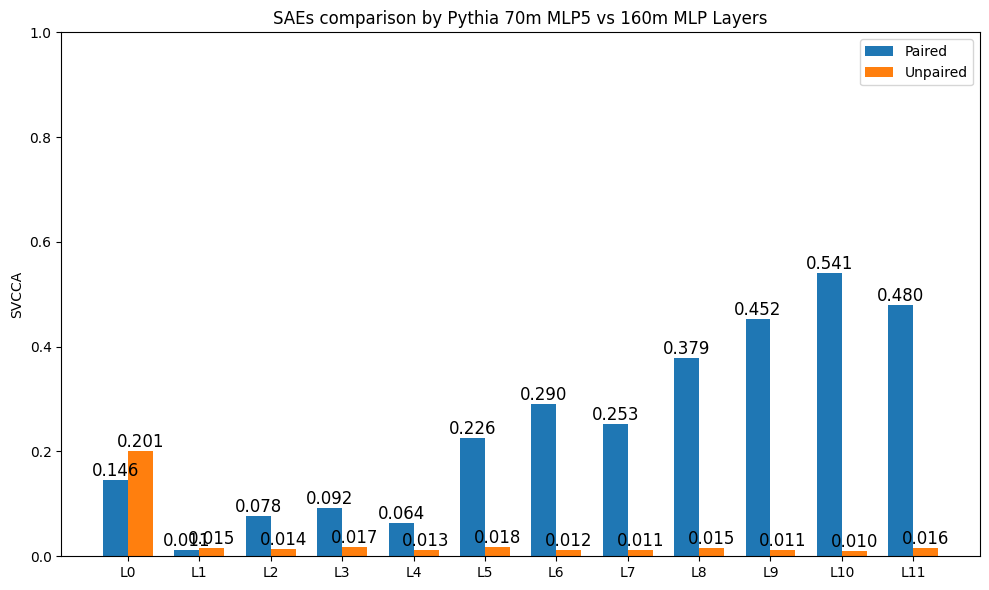

In [84]:
plot_svcca_byLayer(layer_to_dictscores)

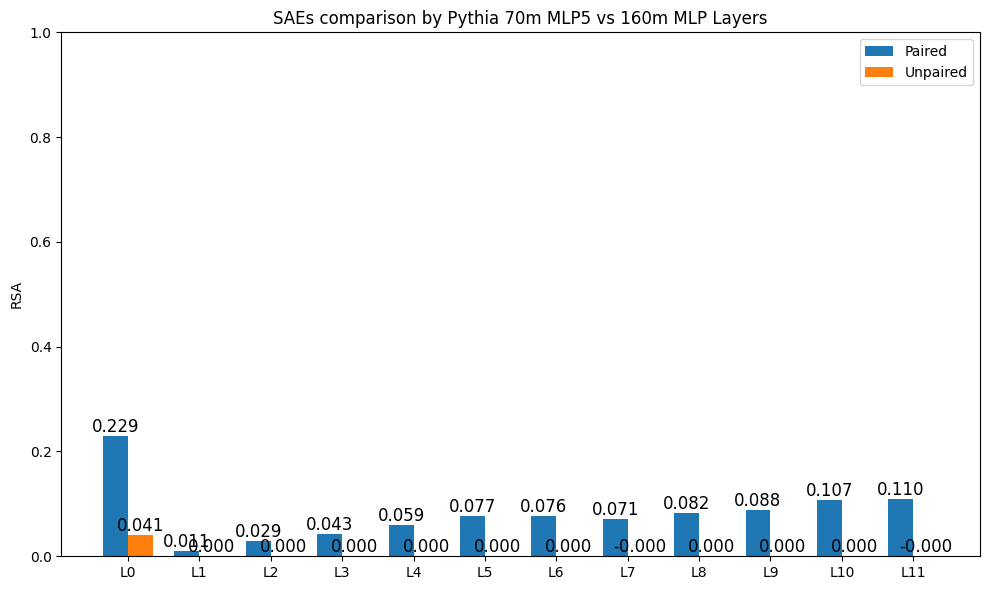

In [85]:
plot_rsa_byLayer(layer_to_dictscores)

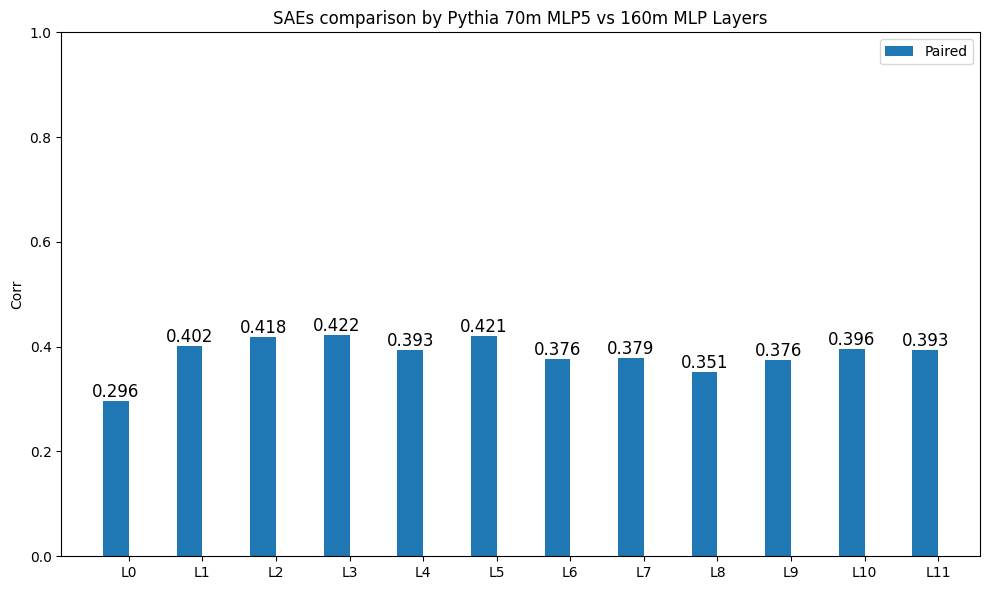

In [86]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

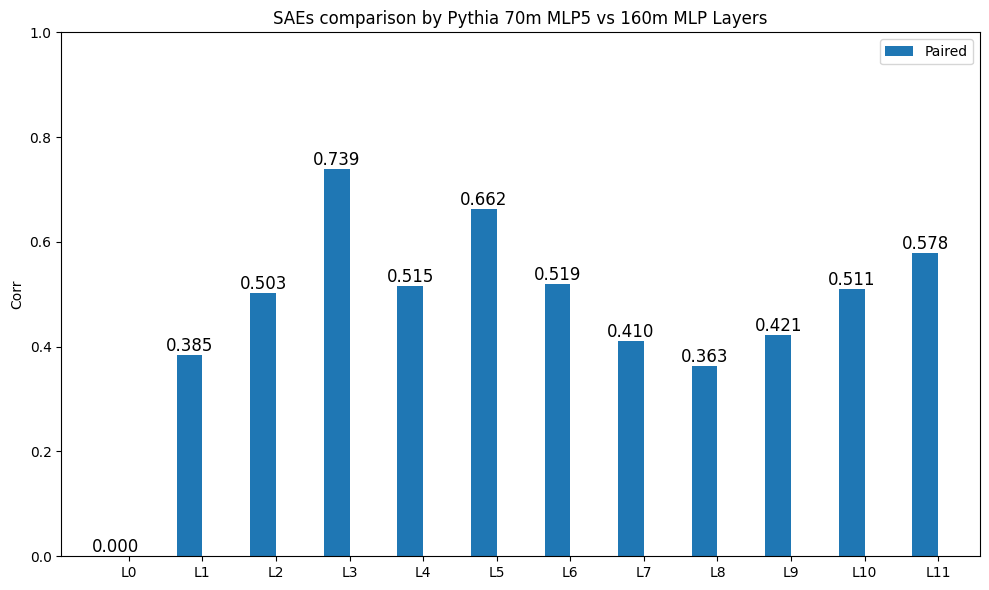

In [87]:
plot_meanCorr_byLayer(layer_to_dictscores)

In [88]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_kept'])

0 8
1 3079
2 3048
3 1879
4 3160
5 2574
6 3020
7 3831
8 3793
9 3670
10 3354
11 2688


In [89]:
for key, val in layer_to_dictscores.items():
    print(key, val['num_feat_A_unique'])

0 8
1 3079
2 3048
3 1879
4 3160
5 2574
6 3020
7 3831
8 3793
9 3670
10 3354
11 2688
